# Notebook 05: creditcard Neural Network Training & Regularization

**Dataset**: creditcard.csv (Real-World ULB)

**Objective**: Apply best architecture from card_transdata experiments and test 8 regularization strategies (REG-01 to REG-08) to optimize NN performance on production data.

**Primary Metric**: PR-AUC (optimal for 0.17% fraud rate)

**Goal**: Beat or match Random Forest baseline from Notebook 04 using neural networks.

**Experiments**:
1. Transfer best architecture from Notebook 03 (card_transdata)
2. Test 8 regularization configurations (REG-01 to REG-08)
3. Select best NN model for final test evaluation

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import joblib
import sys
import os
import json
from pathlib import Path

# Add src to path
sys.path.append(os.path.abspath('../'))
import config
from src.nn_architectures import build_fraud_detection_nn
from src.nn_training_utils import train_nn_with_early_stopping, log_experiment
from src.evaluation_metrics import compute_fraud_metrics, print_classification_summary
from src.visualization_utils import (
    plot_training_history,
    plot_confusion_matrix,
    plot_precision_recall_curve
)

# Set random seeds
config.set_random_seeds()

# Get dataset config
ds_config = config.get_dataset_config('creditcard')

print("✓ Imports complete")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Random seed set to {config.RANDOM_SEED}")
print(f"✓ Dataset: creditcard.csv (Real-World ULB)")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


✓ Imports complete
✓ TensorFlow version: 2.15.0
✓ Random seed set to 42
✓ Dataset: creditcard.csv (Real-World ULB)


## 1. Load Preprocessed Data

In [2]:
# Load original data
df = pd.read_csv(ds_config['data_path'])
X = df[ds_config['feature_cols']].values
y = df[ds_config['target_col']].values

# Load saved split indices
train_idx = np.load(ds_config['train_idx'])
val_idx = np.load(ds_config['val_idx'])
test_idx = np.load(ds_config['test_idx'])

# Split data using saved indices
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Load fitted scaler
scaler = joblib.load(ds_config['scaler_path'])

# Transform data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Data loaded and preprocessed:")
print(f"  Train: {X_train_scaled.shape[0]:,} samples")
print(f"  Val:   {X_val_scaled.shape[0]:,} samples")
print(f"  Test:  {X_test_scaled.shape[0]:,} samples (RESERVED for Notebook 06)")
print(f"  Features: {X_train_scaled.shape[1]}")
print(f"\n✓ Class distribution:")
print(f"  Train fraud rate: {y_train.mean()*100:.4f}%")
print(f"  Val fraud rate:   {y_val.mean()*100:.4f}%")

✓ Data loaded and preprocessed:
  Train: 199,364 samples
  Val:   42,721 samples
  Test:  42,722 samples (RESERVED for Notebook 06)
  Features: 30

✓ Class distribution:
  Train fraud rate: 0.1725%
  Val fraud rate:   0.1732%


## 2. Load Baseline Performance Targets

In [3]:
# Load baseline results from Notebook 04
baseline_results = pd.read_csv(ds_config['tables_dir'] / 'baseline_results.csv')

print("📊 Baseline Performance Targets (Validation Set):")
print("="*60)
print(baseline_results.to_string(index=False))
print("="*60)

# Extract RF performance as target
rf_pr_auc = baseline_results[baseline_results['model'] == 'Random Forest']['pr_auc'].values[0]
rf_f1 = baseline_results[baseline_results['model'] == 'Random Forest']['f1_fraud'].values[0]

print(f"\n🎯 Target to Beat/Match:")
print(f"   Random Forest PR-AUC: {rf_pr_auc:.4f}")
print(f"   Random Forest F1:     {rf_f1:.4f}")

📊 Baseline Performance Targets (Validation Set):
              model   pr_auc  roc_auc  f1_fraud  precision_fraud  recall_fraud  accuracy
Logistic Regression 0.630087 0.968390   0.12464         0.067079      0.878378  0.978629
      Random Forest 0.798698 0.930116   0.80315         0.962264      0.689189  0.999415

🎯 Target to Beat/Match:
   Random Forest PR-AUC: 0.7987
   Random Forest F1:     0.8031


## 3. Load Best Architecture from card_transdata Experiments

In [4]:
# Load architecture ranking from Notebook 03
card_transdata_results = config.RESULTS_DIR / 'card_transdata' / 'tables' / 'architecture_ranking.csv'

if card_transdata_results.exists():
    arch_ranking = pd.read_csv(card_transdata_results)
    best_arch = arch_ranking.iloc[0]
    
    print("✓ Loaded best architecture from card_transdata experiments:")
    print(f"  Experiment ID: {best_arch['experiment_id']}")
    print(f"  Architecture: {best_arch['architecture']}")
    print(f"  Layers: {best_arch['layers']}")
    print(f"  card_transdata PR-AUC: {best_arch['pr_auc']:.4f}")
    
    # Parse layers string back to list
    import ast
    best_arch_layers = ast.literal_eval(best_arch['layers'])
    print(f"\n🚀 Transferring architecture to creditcard dataset...")
else:
    print("⚠️  Warning: No architecture ranking found from Notebook 03")
    print("   Using default architecture: [64, 32]")
    best_arch_layers = [64, 32]
    best_arch = {'experiment_id': 'DEFAULT', 'architecture': 'balanced_medium'}

✓ Loaded best architecture from card_transdata experiments:
  Experiment ID: ARCH-06
  Architecture: wide_medium
  Layers: [256]
  card_transdata PR-AUC: 0.9966

🚀 Transferring architecture to creditcard dataset...


## 4. Regularization Experiments (REG-01 to REG-08)

Test 8 regularization strategies on real-world data using transferred architecture.

In [5]:
# Initialize experiment log
regularization_results = []

# Create results directory
(ds_config['models_dir'] / 'neural_networks').mkdir(parents=True, exist_ok=True)
(ds_config['experiment_logs_dir']).mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print(" REGULARIZATION EXPERIMENTS: Testing 8 Strategies")
print("="*70)
print(f"Architecture: {best_arch_layers}")
print(f"Dataset: creditcard.csv (Real-World ULB)")
print(f"Target: RF PR-AUC = {rf_pr_auc:.4f}")
print("="*70)


 REGULARIZATION EXPERIMENTS: Testing 8 Strategies
Architecture: [256]
Dataset: creditcard.csv (Real-World ULB)
Target: RF PR-AUC = 0.7987



Training REG-01: Baseline
Dropout=0.0, L2=0.0, BatchNorm=False

Class weights (balanced): {0: 0.5008642347502763, 1: 289.7732558139535}
Epoch 1/100


3116/3116 [==============================] - 9s 2ms/step - loss: 0.2142 - accuracy: 0.9770 - precision: 0.0633 - recall: 0.8953 - auc: 0.9629 - pr_auc: 0.5885 - val_loss: 0.2077 - val_accuracy: 0.9357 - val_precision: 0.0235 - val_recall: 0.8919 - val_auc: 0.9724 - val_pr_auc: 0.3372 - lr: 0.0010
Epoch 2/100
3116/3116 [==============================] - 6s 2ms/step - loss: 0.1185 - accuracy: 0.9738 - precision: 0.0587 - recall: 0.9448 - auc: 0.9889 - pr_auc: 0.6666 - val_loss: 0.0957 - val_accuracy: 0.9730 - val_precision: 0.0522 - val_recall: 0.8514 - val_auc: 0.9728 - val_pr_auc: 0.5405 - lr: 0.0010
Epoch 3/100
3116/3116 [==============================] - 6s 2ms/step - loss: 0.1076 - accuracy: 0.9754 - precision: 0.0626 - recall: 0.9506 - auc: 0.9912 - pr_auc: 0.6219 - val_loss: 0.0611 - val_accuracy: 0.9813 - val_precision: 0.0739 - va

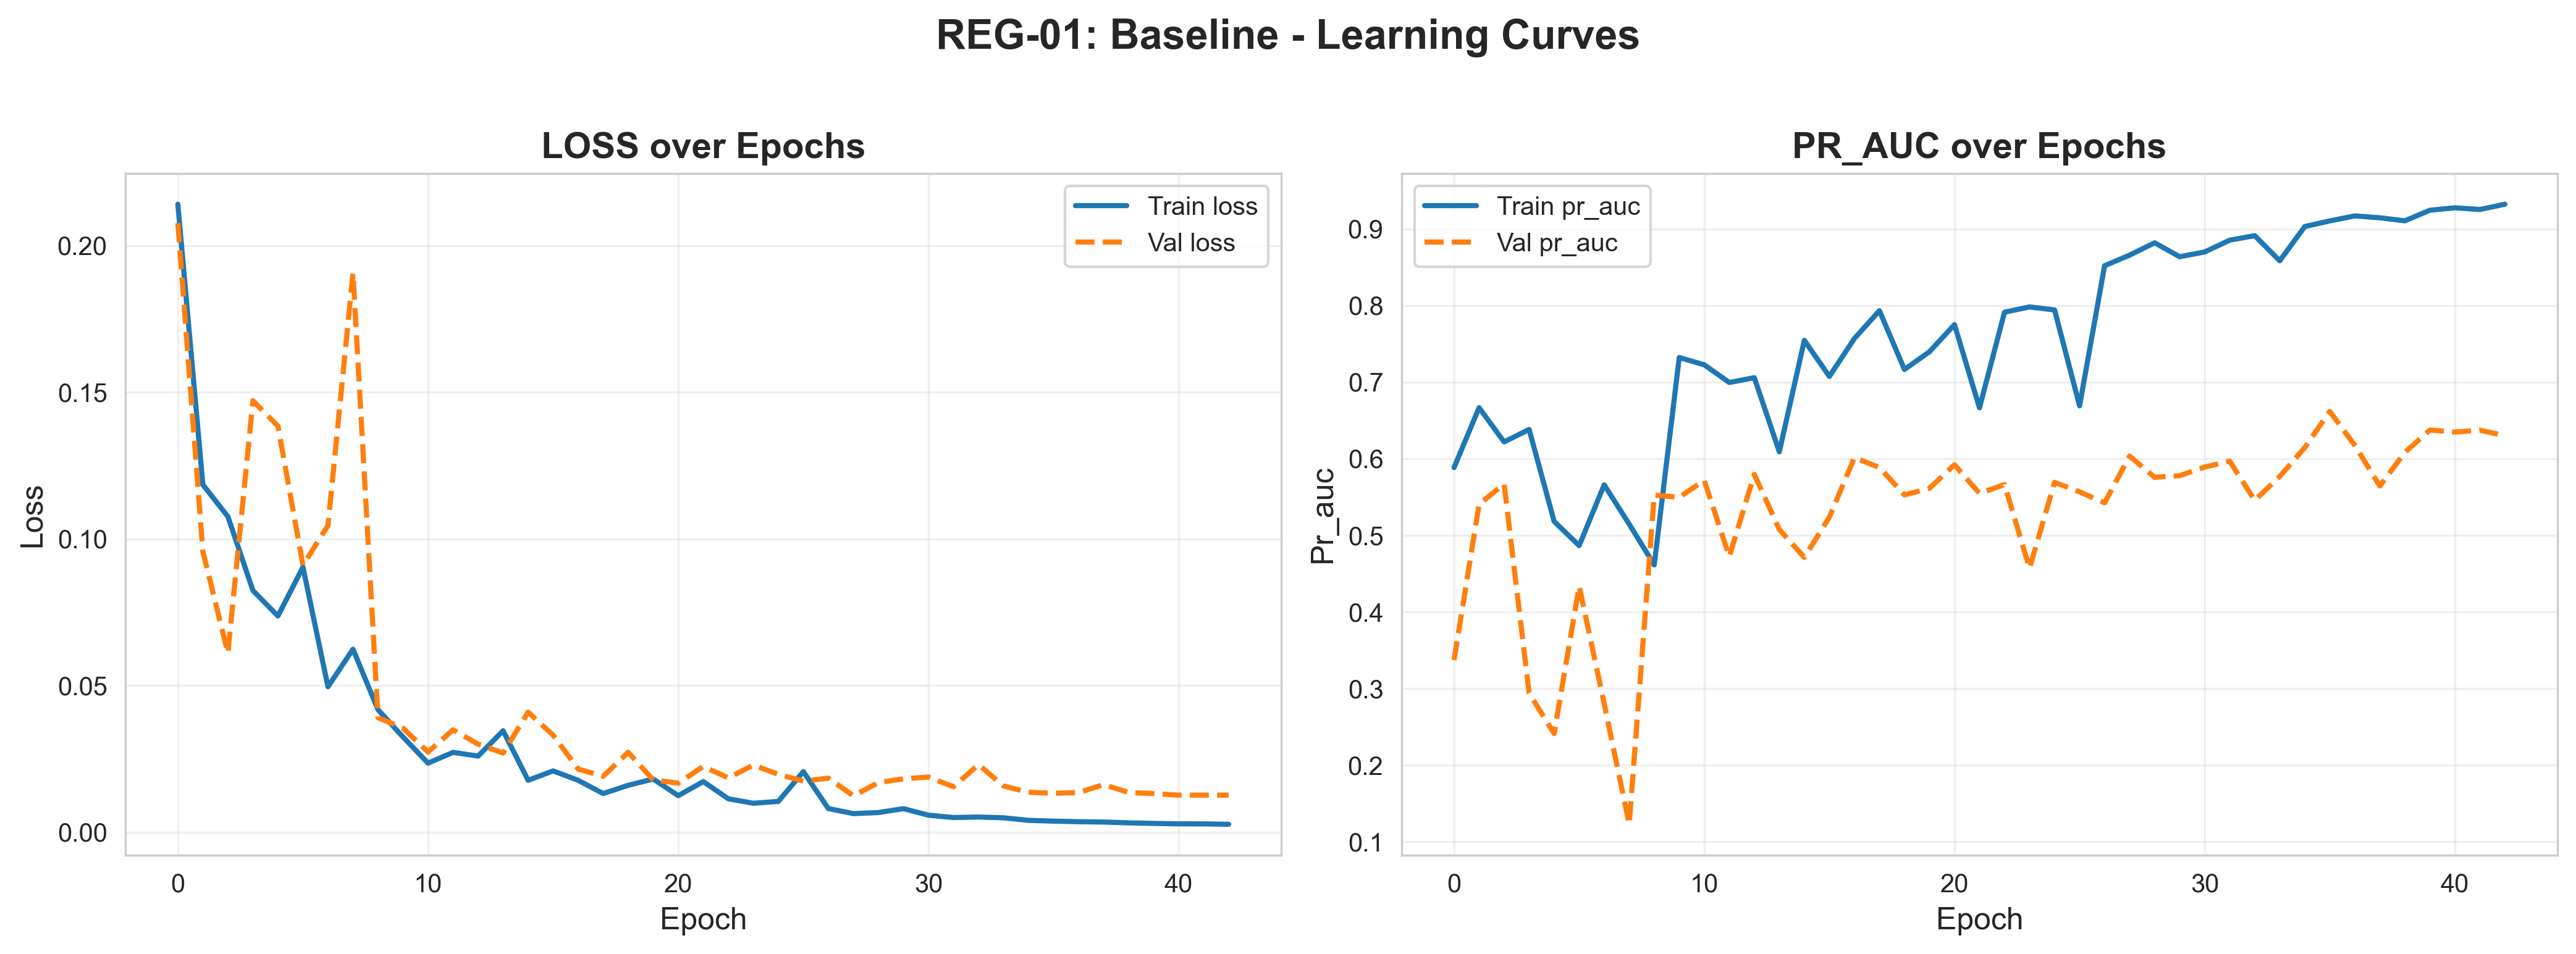

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\logs\nn_experiments.csv

Training REG-02: Light dropout
Dropout=0.2, L2=0.0, BatchNorm=False
Class weights (balanced): {0: 0.5008642347502763, 1: 289.7732558139535}
Epoch 1/100
3116/3116 [==============================] - 11s 3ms/step - loss: 0.2202 - accuracy: 0.9793 - precision: 0.0696 - recall: 0.8895 - auc: 0.9606 - pr_auc: 0.6210 - val_loss: 0.1672 - val_accuracy: 0.9556 - val_precision: 0.0333 - val_recall: 0.8784 - val_auc: 0.9657 - val_pr_auc: 0.4458 - lr: 0.0010
Epoch 2/100
3116/3116 [==============================] - 8s 3ms/step - loss: 0.1369 - accuracy: 0.9664 - precision: 0.0462 - recall: 0.9390 - auc: 0.9863 - pr_auc: 0.4410 - val_loss: 0.0803 - val_accuracy: 0.9783 - val_precision: 0.0653 - val_recall: 0.8649 - val_auc: 0.9697 - val_pr_auc: 0.5412 - lr: 0.0010
Epoch 3/100
3116/3116 [==============================] - 8s 2ms/step - loss: 0.1269 - accuracy: 0.9709 - precision: 0.0531 - recall: 0.9

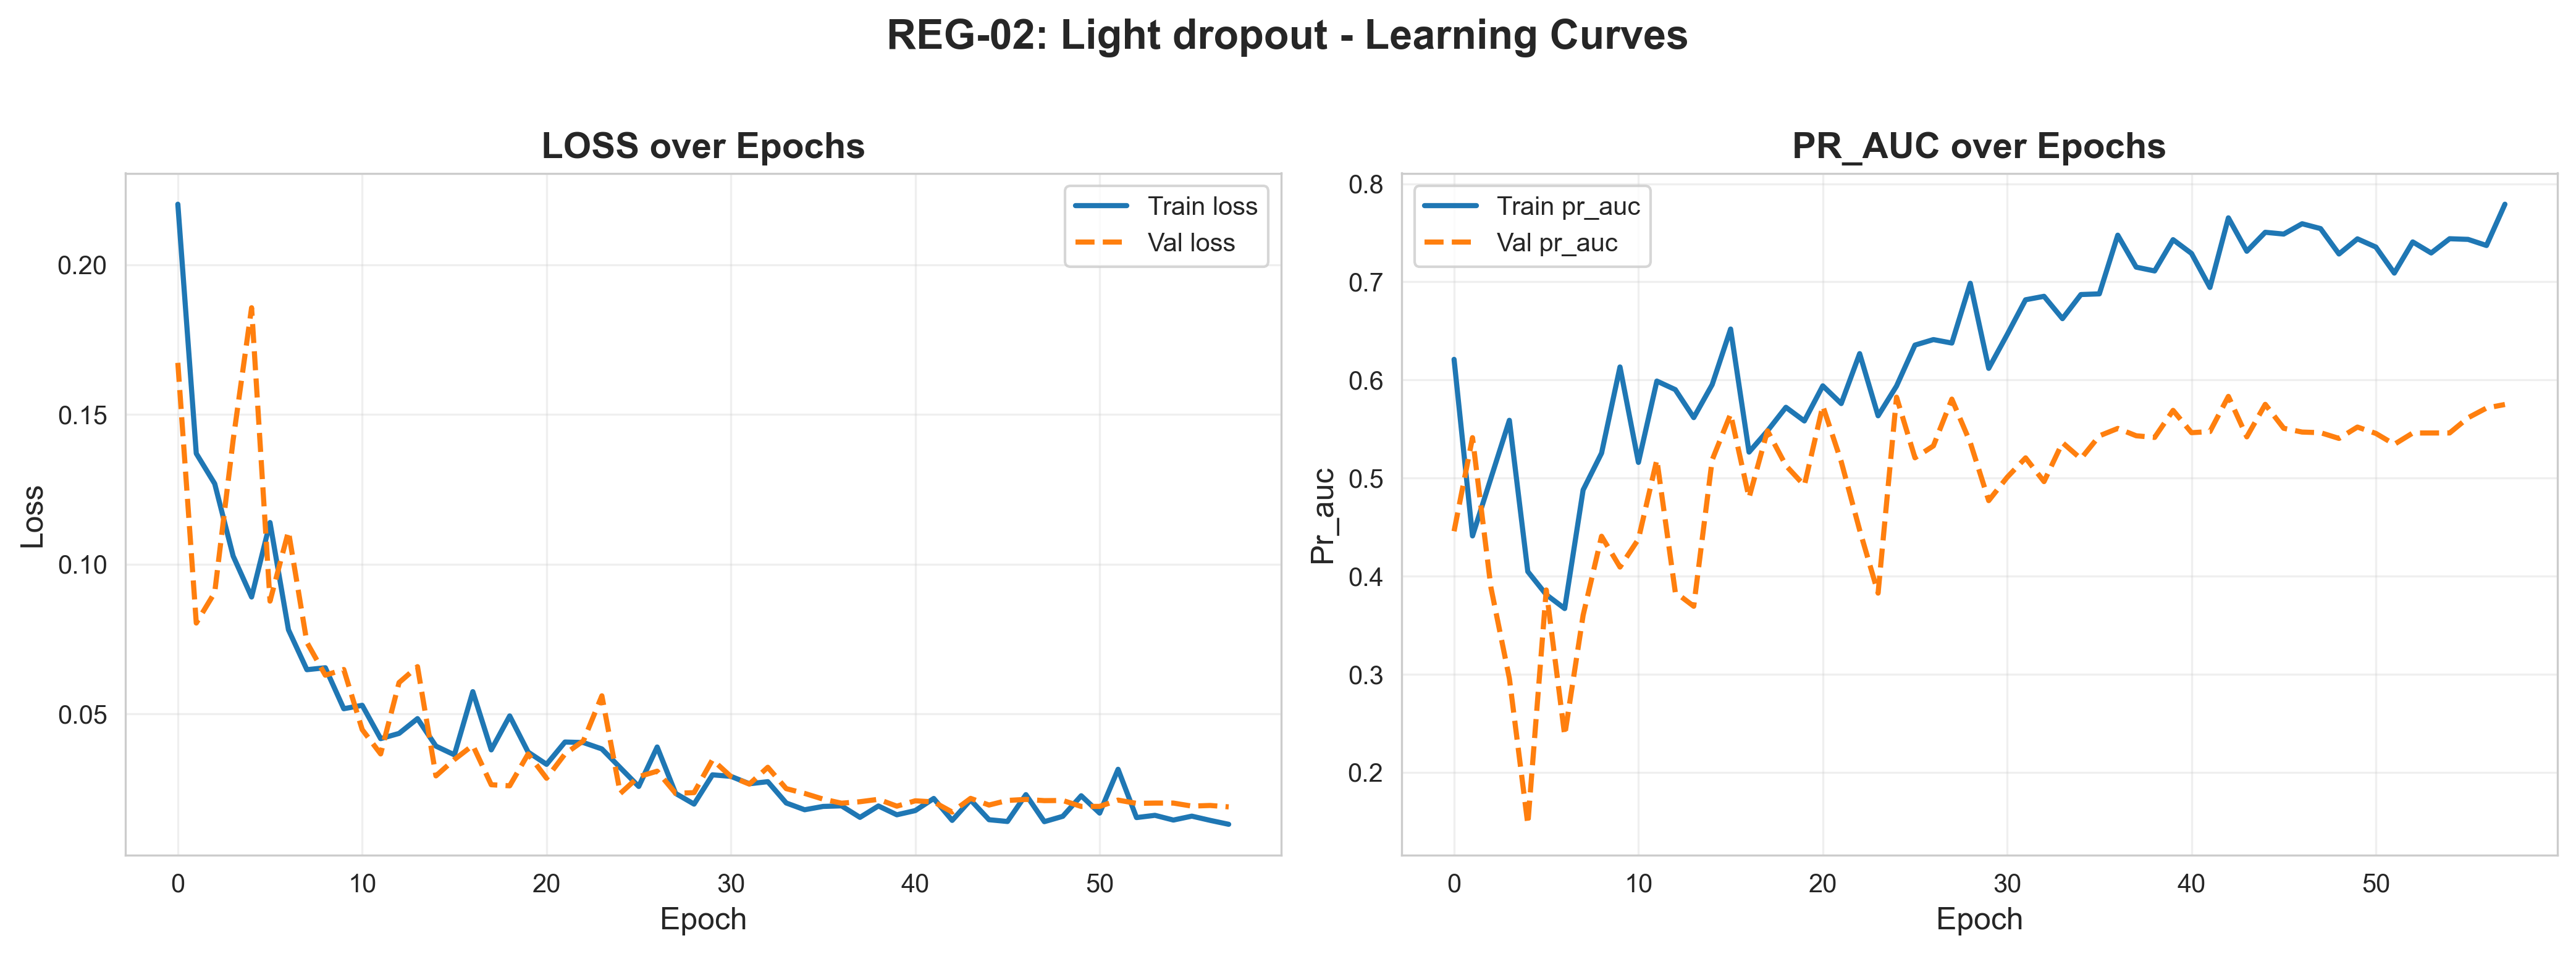

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\logs\nn_experiments.csv

Training REG-03: Medium dropout
Dropout=0.3, L2=0.0, BatchNorm=False
Class weights (balanced): {0: 0.5008642347502763, 1: 289.7732558139535}
Epoch 1/100
3116/3116 [==============================] - 9s 3ms/step - loss: 0.2072 - accuracy: 0.9775 - precision: 0.0648 - recall: 0.8983 - auc: 0.9645 - pr_auc: 0.5673 - val_loss: 0.1595 - val_accuracy: 0.9572 - val_precision: 0.0355 - val_recall: 0.9054 - val_auc: 0.9746 - val_pr_auc: 0.3721 - lr: 0.0010
Epoch 2/100
3116/3116 [==============================] - 8s 2ms/step - loss: 0.1484 - accuracy: 0.9644 - precision: 0.0432 - recall: 0.9273 - auc: 0.9839 - pr_auc: 0.4366 - val_loss: 0.0708 - val_accuracy: 0.9830 - val_precision: 0.0821 - val_recall: 0.8649 - val_auc: 0.9750 - val_pr_auc: 0.4872 - lr: 0.0010
Epoch 3/100
3116/3116 [==============================] - 8s 2ms/step - loss: 0.1281 - accuracy: 0.9680 - precision: 0.0480 - recall: 0.9

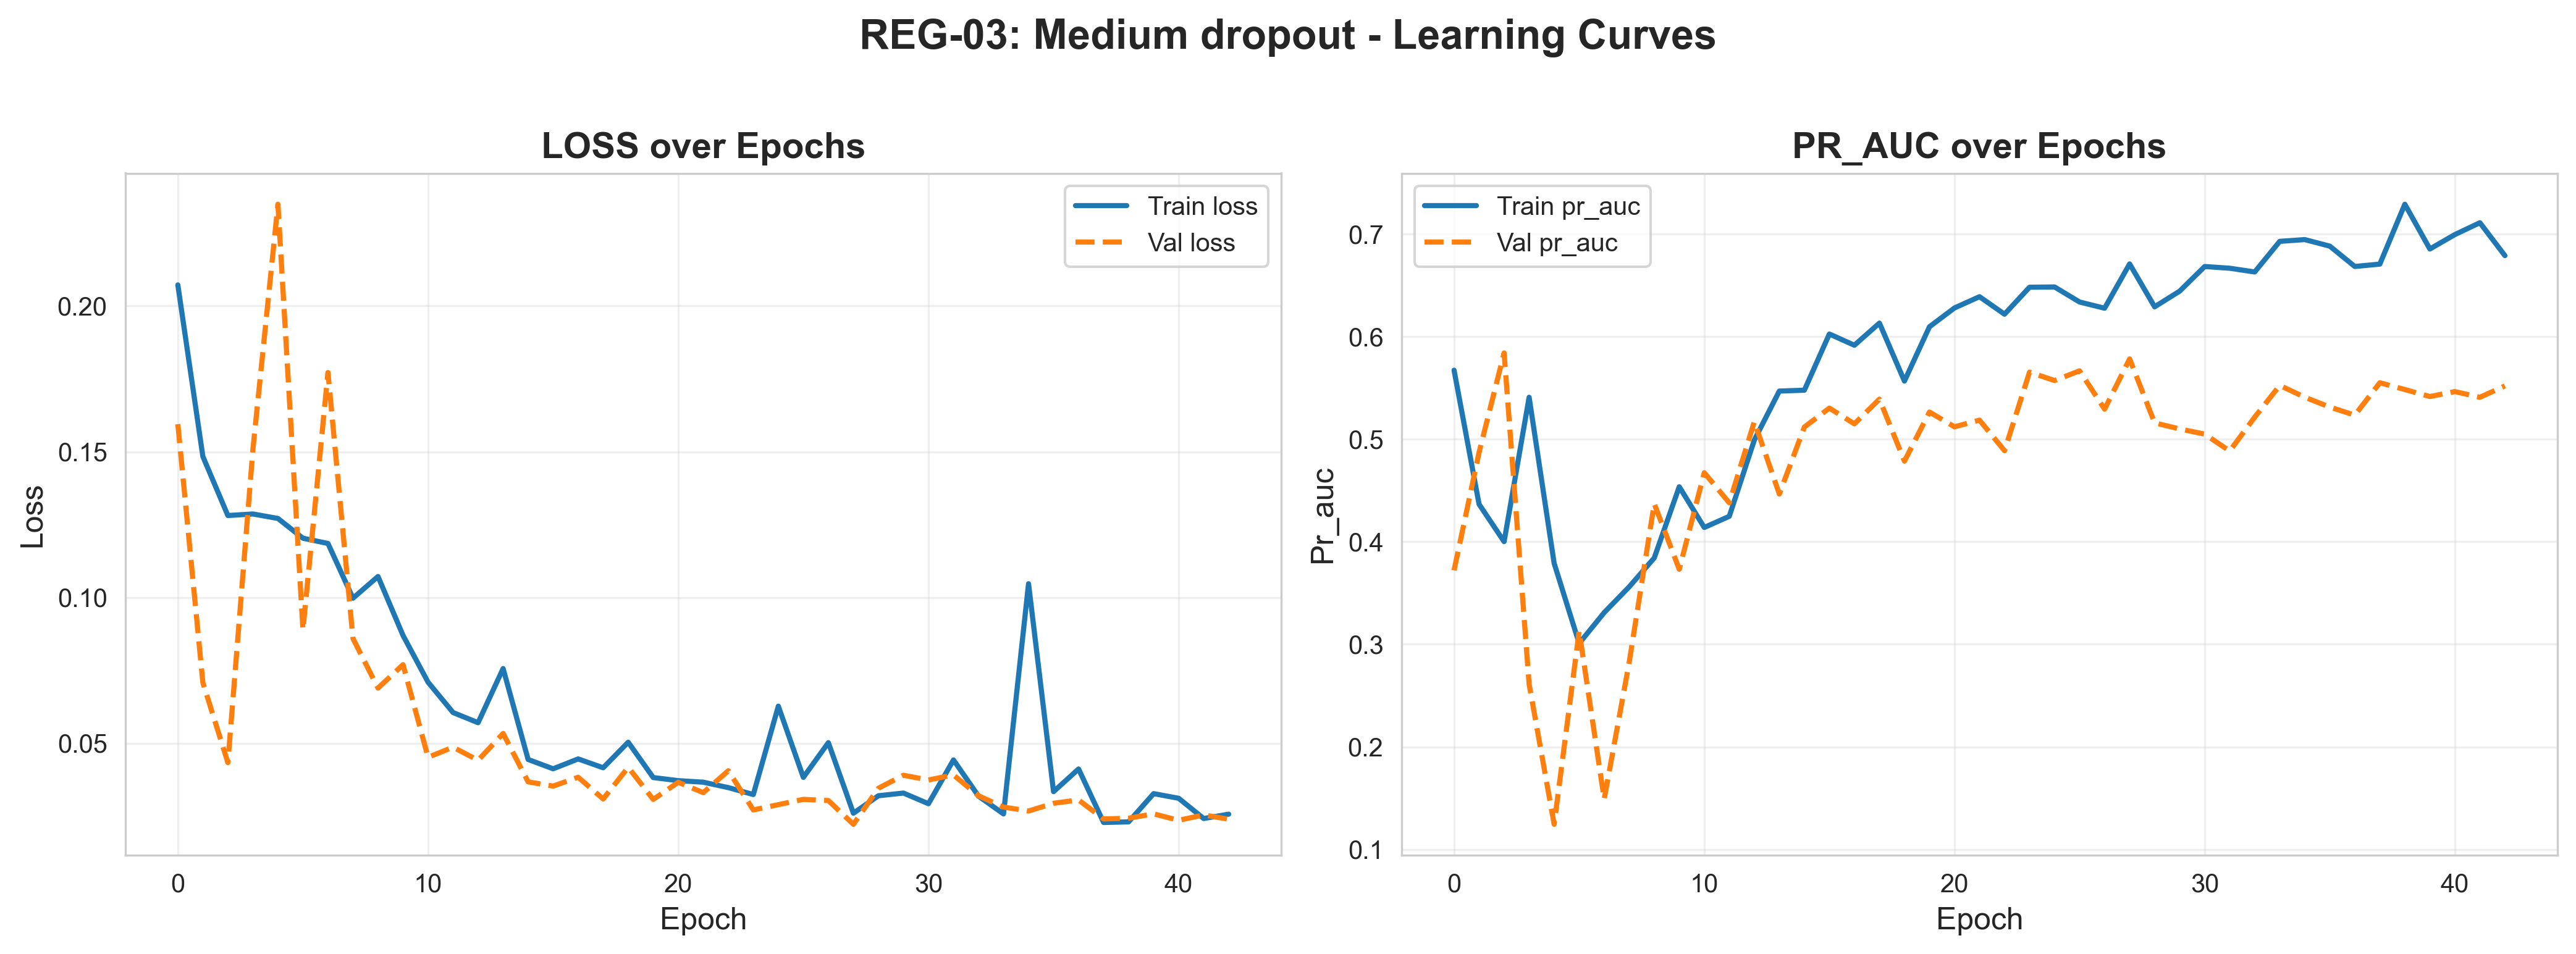

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\logs\nn_experiments.csv

Training REG-04: Heavy dropout
Dropout=0.4, L2=0.0, BatchNorm=False
Class weights (balanced): {0: 0.5008642347502763, 1: 289.7732558139535}
Epoch 1/100
3116/3116 [==============================] - 13s 4ms/step - loss: 0.2218 - accuracy: 0.9720 - precision: 0.0526 - recall: 0.8953 - auc: 0.9619 - pr_auc: 0.5511 - val_loss: 0.1019 - val_accuracy: 0.9796 - val_precision: 0.0702 - val_recall: 0.8784 - val_auc: 0.9775 - val_pr_auc: 0.5739 - lr: 0.0010
Epoch 2/100
3116/3116 [==============================] - 8s 3ms/step - loss: 0.1597 - accuracy: 0.9665 - precision: 0.0456 - recall: 0.9215 - auc: 0.9800 - pr_auc: 0.4768 - val_loss: 0.1061 - val_accuracy: 0.9697 - val_precision: 0.0475 - val_recall: 0.8649 - val_auc: 0.9719 - val_pr_auc: 0.3898 - lr: 0.0010
Epoch 3/100
3116/3116 [==============================] - 8s 3ms/step - loss: 0.1372 - accuracy: 0.9704 - precision: 0.0517 - recall: 0.9

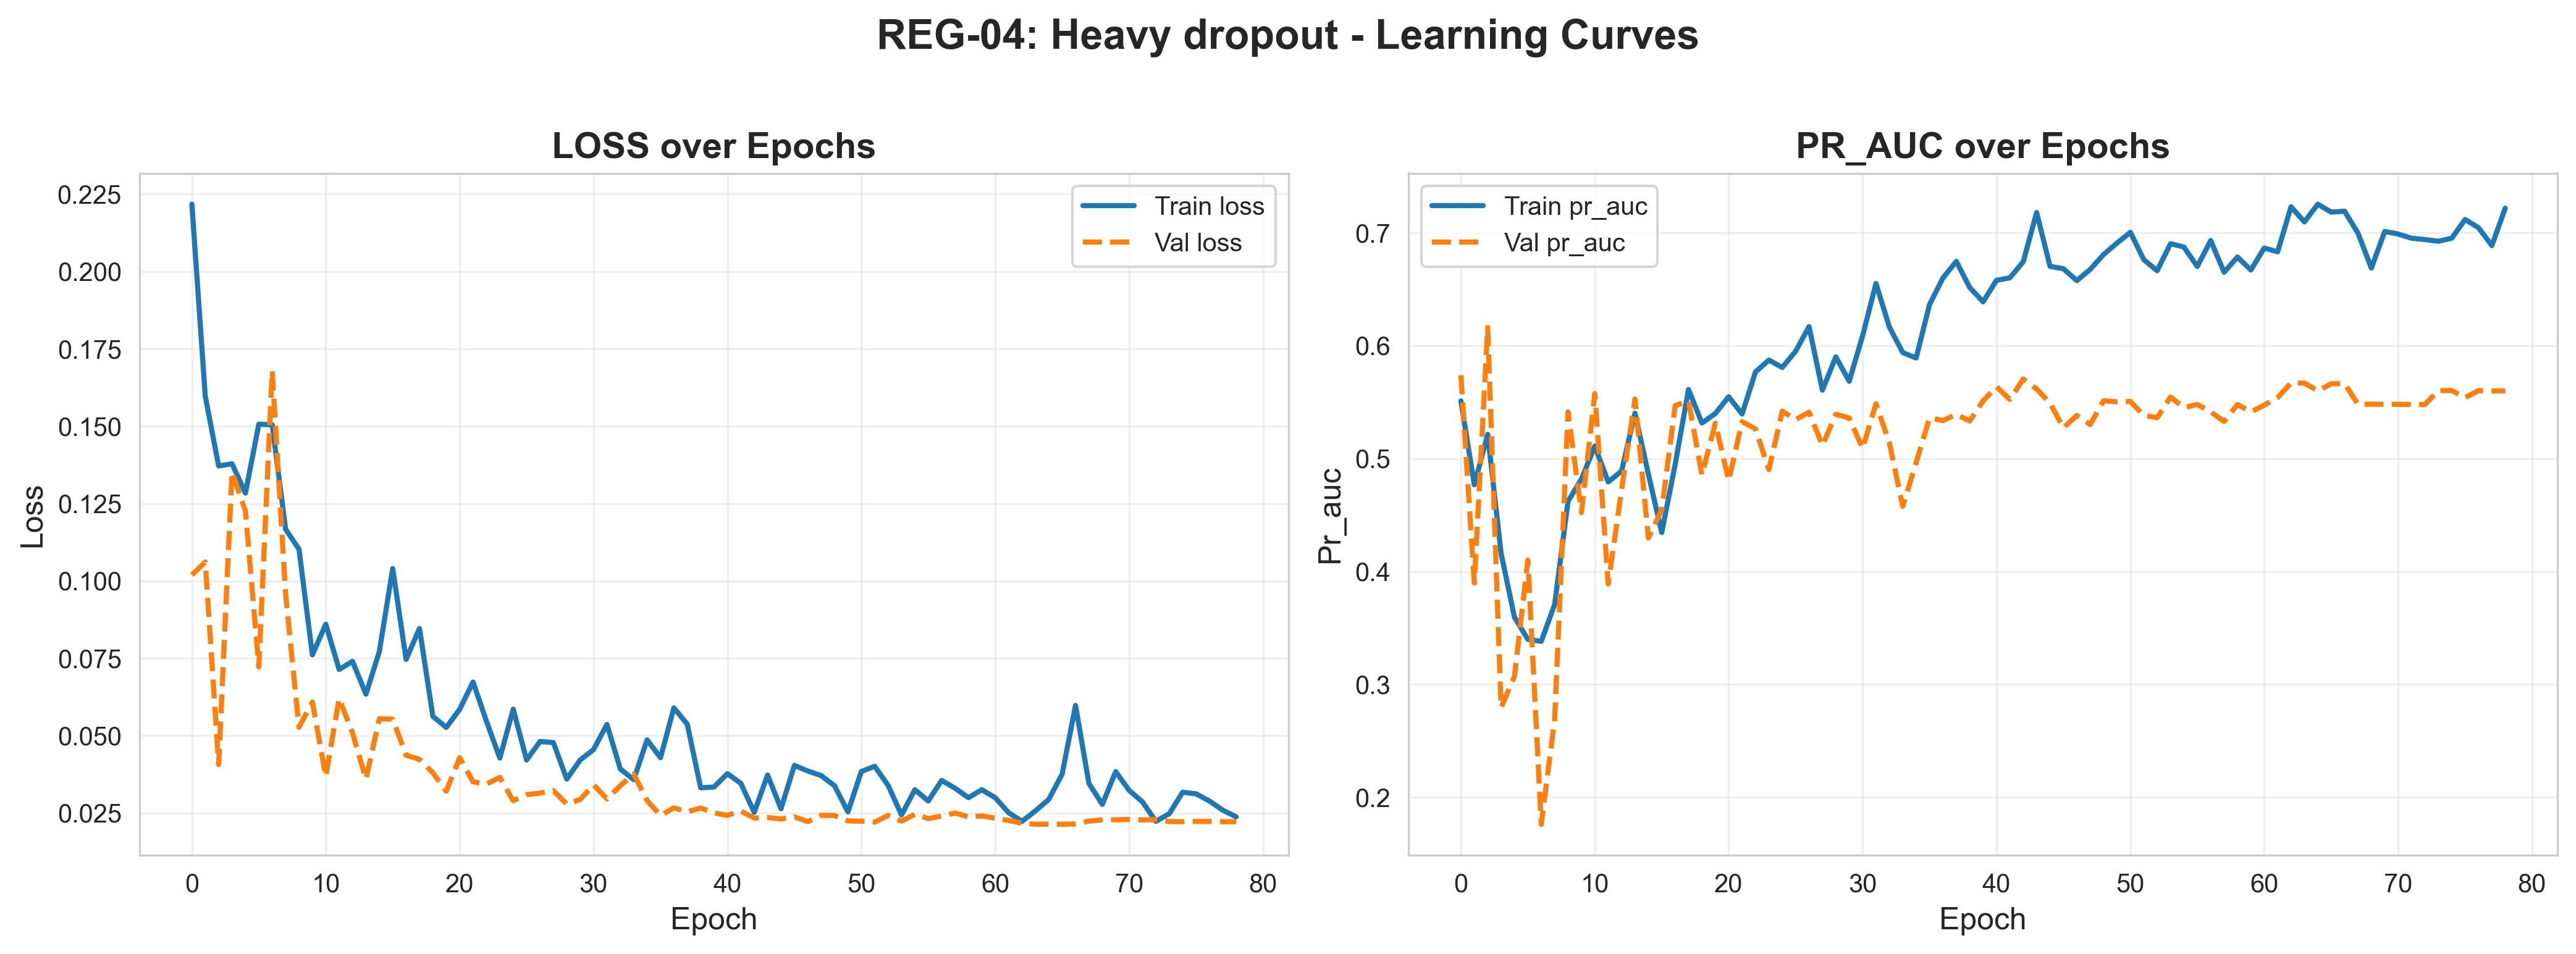

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\logs\nn_experiments.csv

Training REG-05: Light L2
Dropout=0.0, L2=0.001, BatchNorm=False
Class weights (balanced): {0: 0.5008642347502763, 1: 289.7732558139535}
Epoch 1/100
3116/3116 [==============================] - 11s 3ms/step - loss: 0.2559 - accuracy: 0.9770 - precision: 0.0636 - recall: 0.8983 - auc: 0.9622 - pr_auc: 0.6171 - val_loss: 0.2370 - val_accuracy: 0.9441 - val_precision: 0.0274 - val_recall: 0.9054 - val_auc: 0.9739 - val_pr_auc: 0.4700 - lr: 0.0010
Epoch 2/100
3116/3116 [==============================] - 7s 2ms/step - loss: 0.1649 - accuracy: 0.9731 - precision: 0.0570 - recall: 0.9390 - auc: 0.9877 - pr_auc: 0.6649 - val_loss: 0.1297 - val_accuracy: 0.9749 - val_precision: 0.0560 - val_recall: 0.8514 - val_auc: 0.9761 - val_pr_auc: 0.6040 - lr: 0.0010
Epoch 3/100
3116/3116 [==============================] - 7s 2ms/step - loss: 0.1604 - accuracy: 0.9730 - precision: 0.0566 - recall: 0.9360

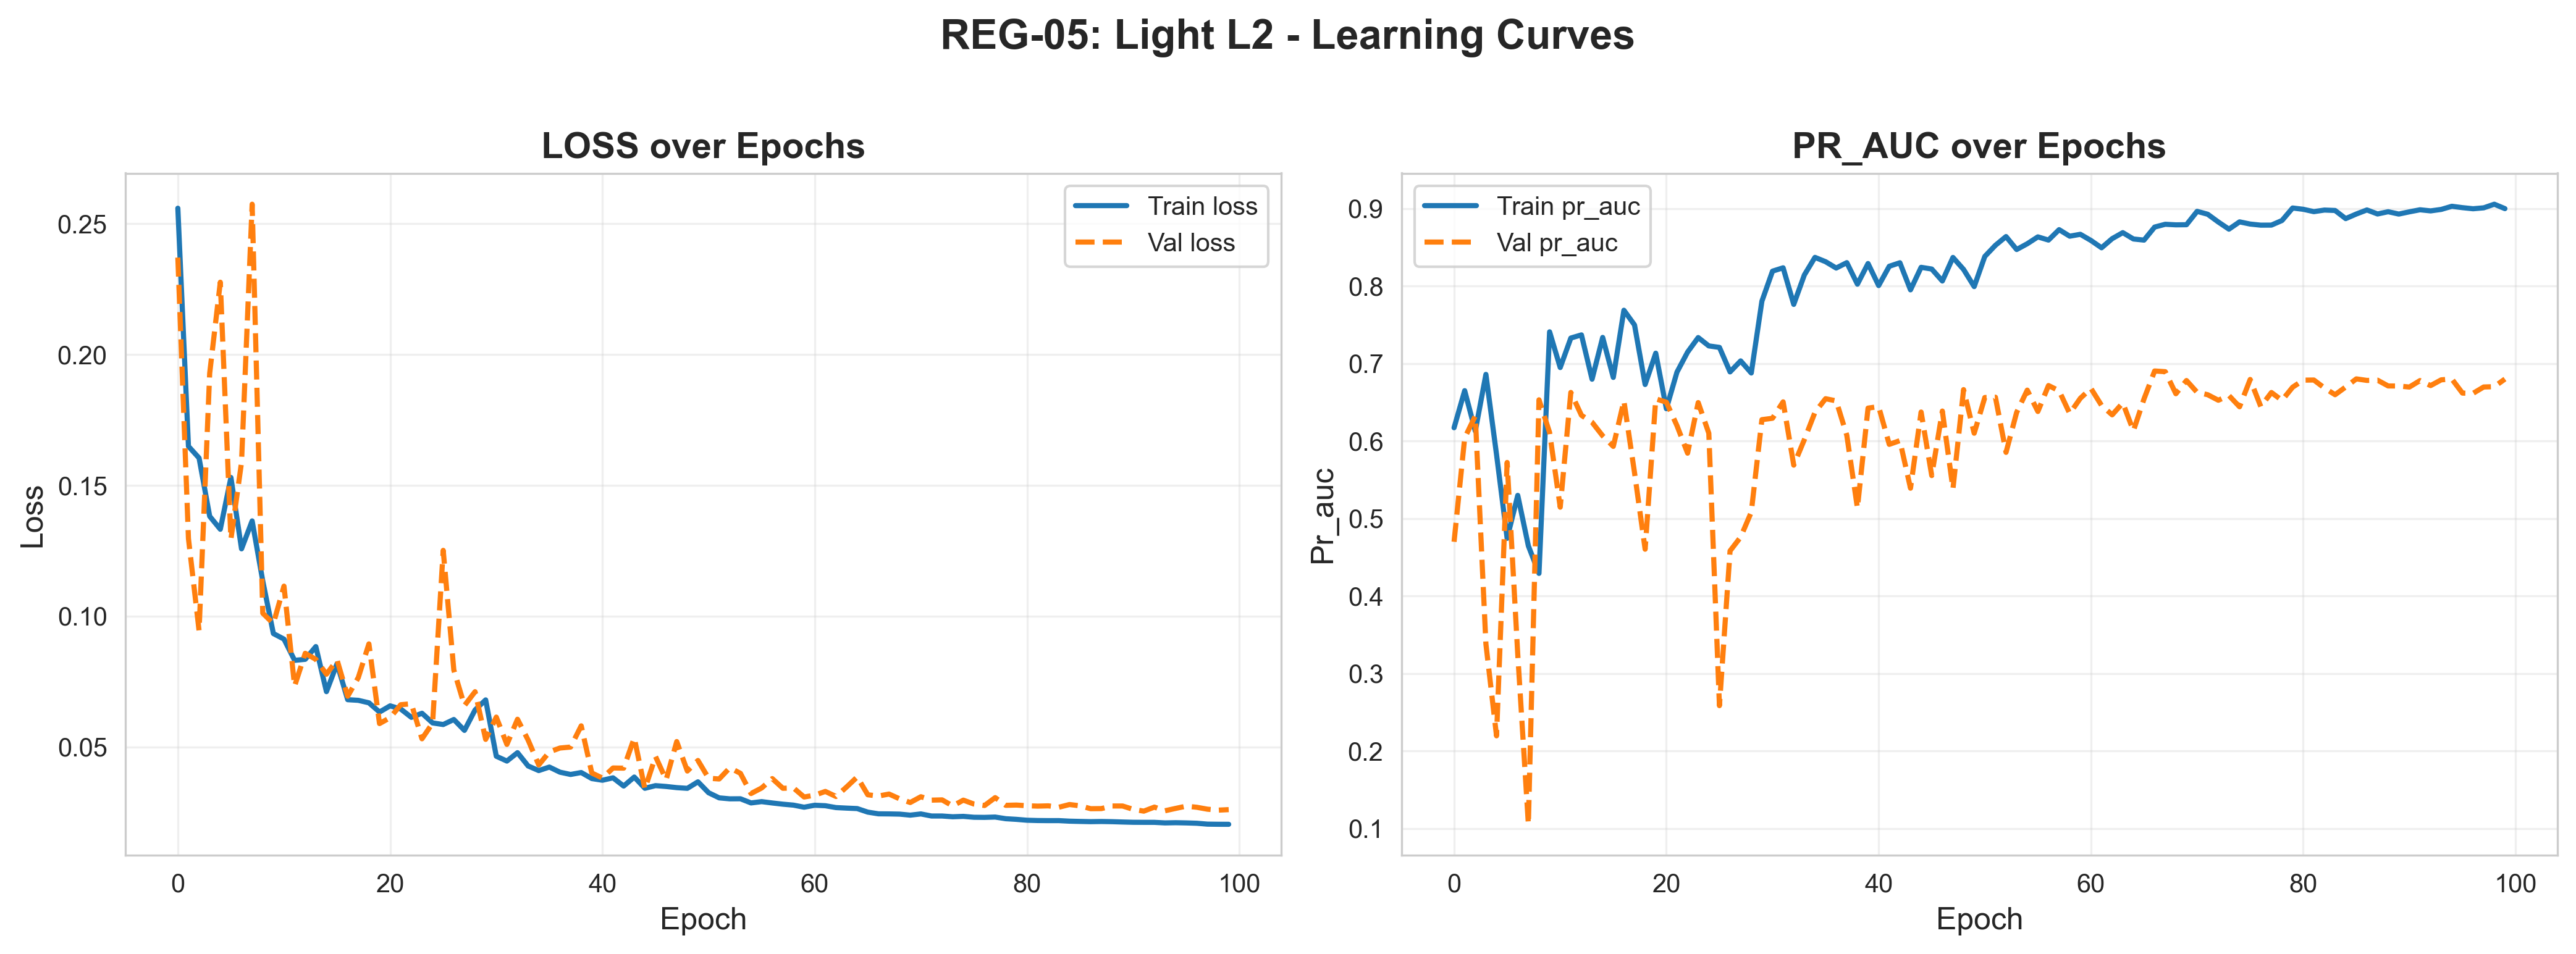

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\logs\nn_experiments.csv

Training REG-06: Medium L2
Dropout=0.0, L2=0.01, BatchNorm=False
Class weights (balanced): {0: 0.5008642347502763, 1: 289.7732558139535}
Epoch 1/100
3116/3116 [==============================] - 9s 2ms/step - loss: 0.3163 - accuracy: 0.9756 - precision: 0.0609 - recall: 0.9099 - auc: 0.9675 - pr_auc: 0.6871 - val_loss: 0.2433 - val_accuracy: 0.9511 - val_precision: 0.0307 - val_recall: 0.8919 - val_auc: 0.9676 - val_pr_auc: 0.6145 - lr: 0.0010
Epoch 2/100
3116/3116 [==============================] - 6s 2ms/step - loss: 0.1975 - accuracy: 0.9696 - precision: 0.0501 - recall: 0.9244 - auc: 0.9802 - pr_auc: 0.6628 - val_loss: 0.1538 - val_accuracy: 0.9662 - val_precision: 0.0422 - val_recall: 0.8514 - val_auc: 0.9646 - val_pr_auc: 0.5727 - lr: 0.0010
Epoch 3/100
3116/3116 [==============================] - 6s 2ms/step - loss: 0.2031 - accuracy: 0.9676 - precision: 0.0469 - recall: 0.9215 

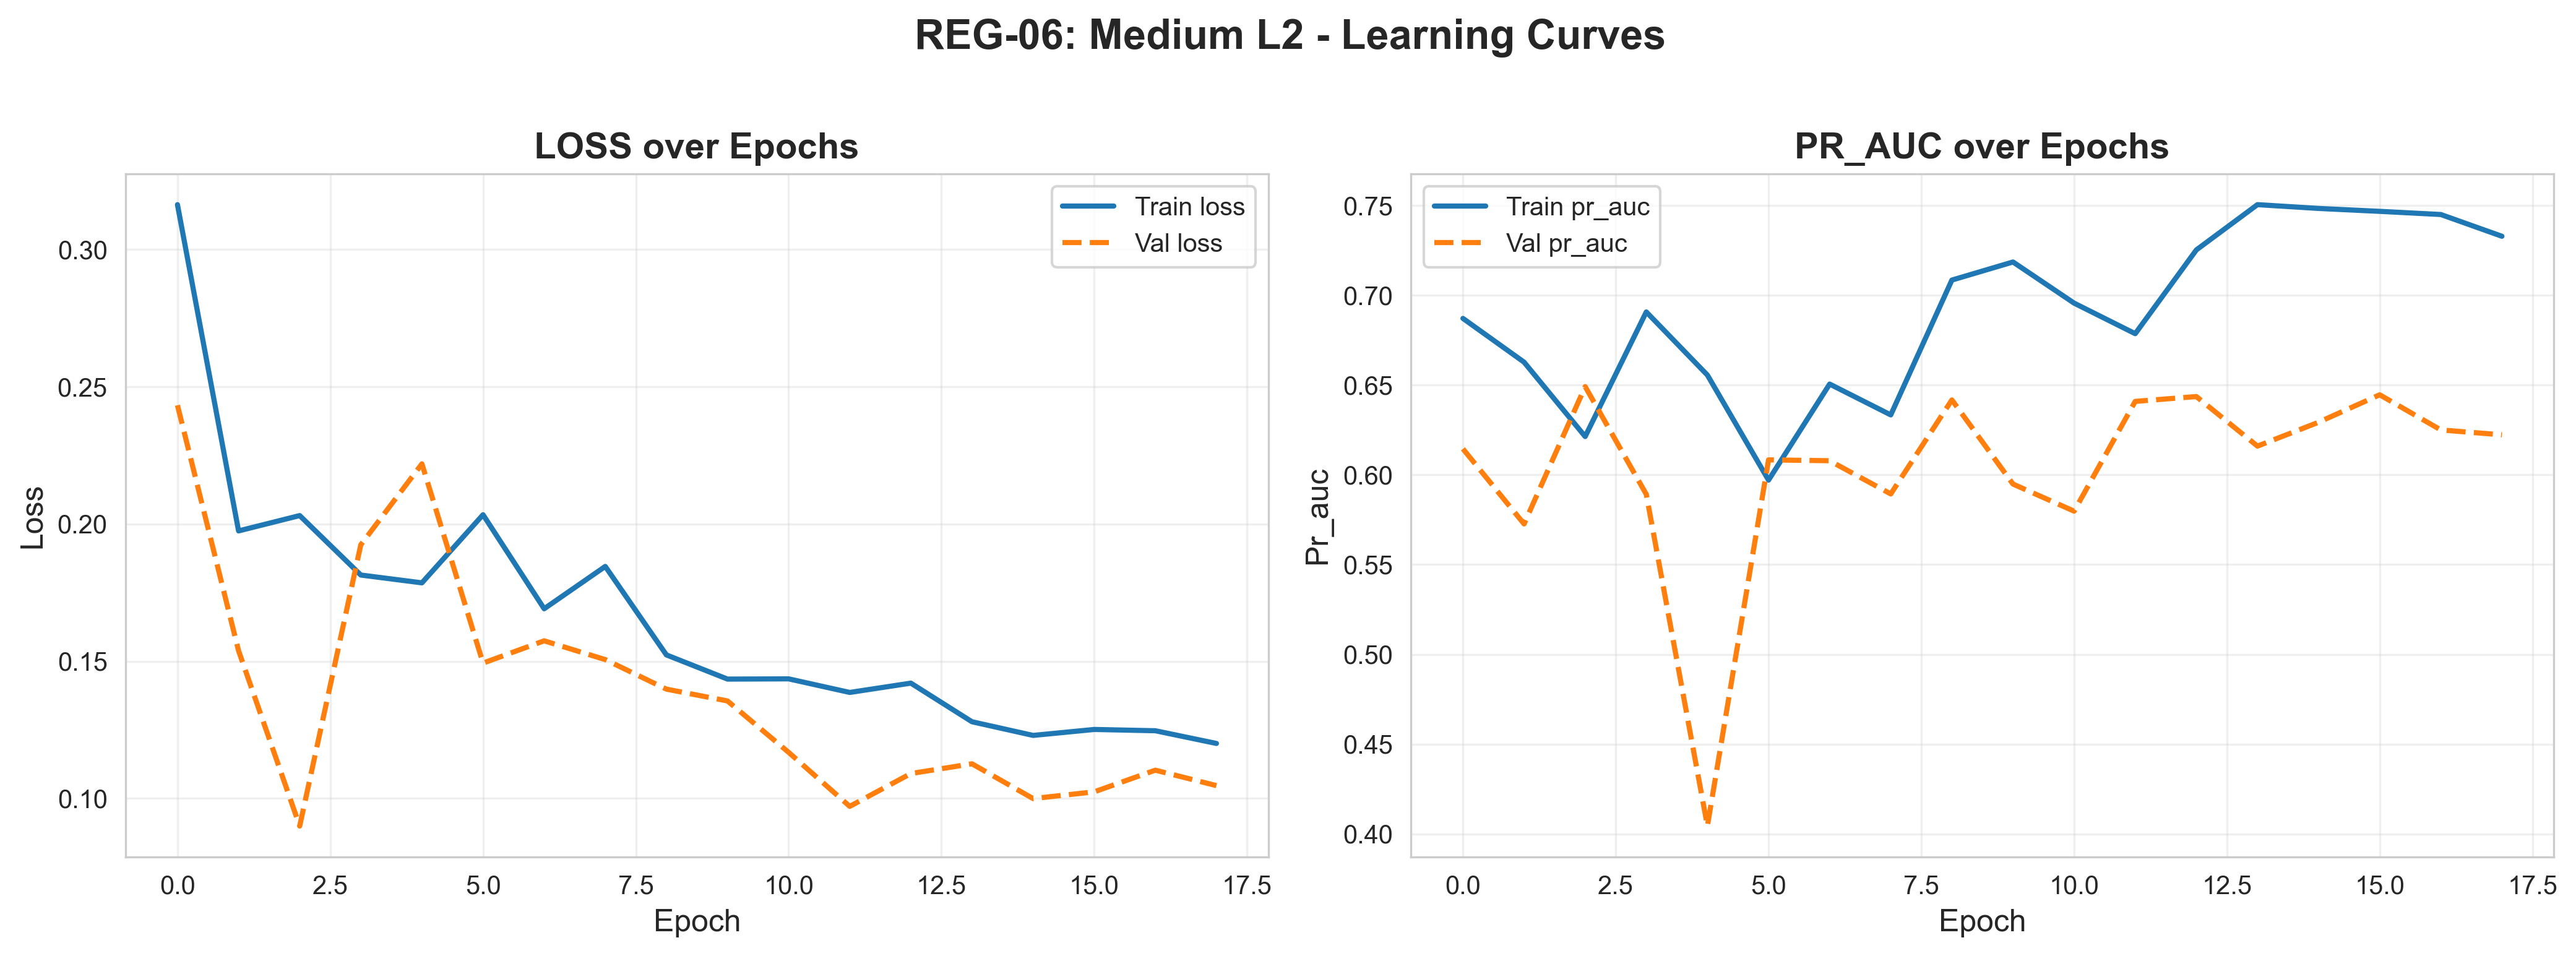

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\logs\nn_experiments.csv

Training REG-07: BatchNorm only
Dropout=0.0, L2=0.0, BatchNorm=True
Class weights (balanced): {0: 0.5008642347502763, 1: 289.7732558139535}
Epoch 1/100
3116/3116 [==============================] - 10s 3ms/step - loss: 0.2338 - accuracy: 0.9451 - precision: 0.0282 - recall: 0.9215 - auc: 0.9626 - pr_auc: 0.2563 - val_loss: 0.2857 - val_accuracy: 0.9320 - val_precision: 0.0223 - val_recall: 0.8919 - val_auc: 0.9573 - val_pr_auc: 0.1250 - lr: 0.0010
Epoch 2/100
3116/3116 [==============================] - 8s 2ms/step - loss: 0.1306 - accuracy: 0.9627 - precision: 0.0422 - recall: 0.9506 - auc: 0.9883 - pr_auc: 0.2538 - val_loss: 0.1187 - val_accuracy: 0.9663 - val_precision: 0.0423 - val_recall: 0.8514 - val_auc: 0.9560 - val_pr_auc: 0.3162 - lr: 0.0010
Epoch 3/100
3116/3116 [==============================] - 8s 2ms/step - loss: 0.1119 - accuracy: 0.9680 - precision: 0.0488 - recall: 0.9

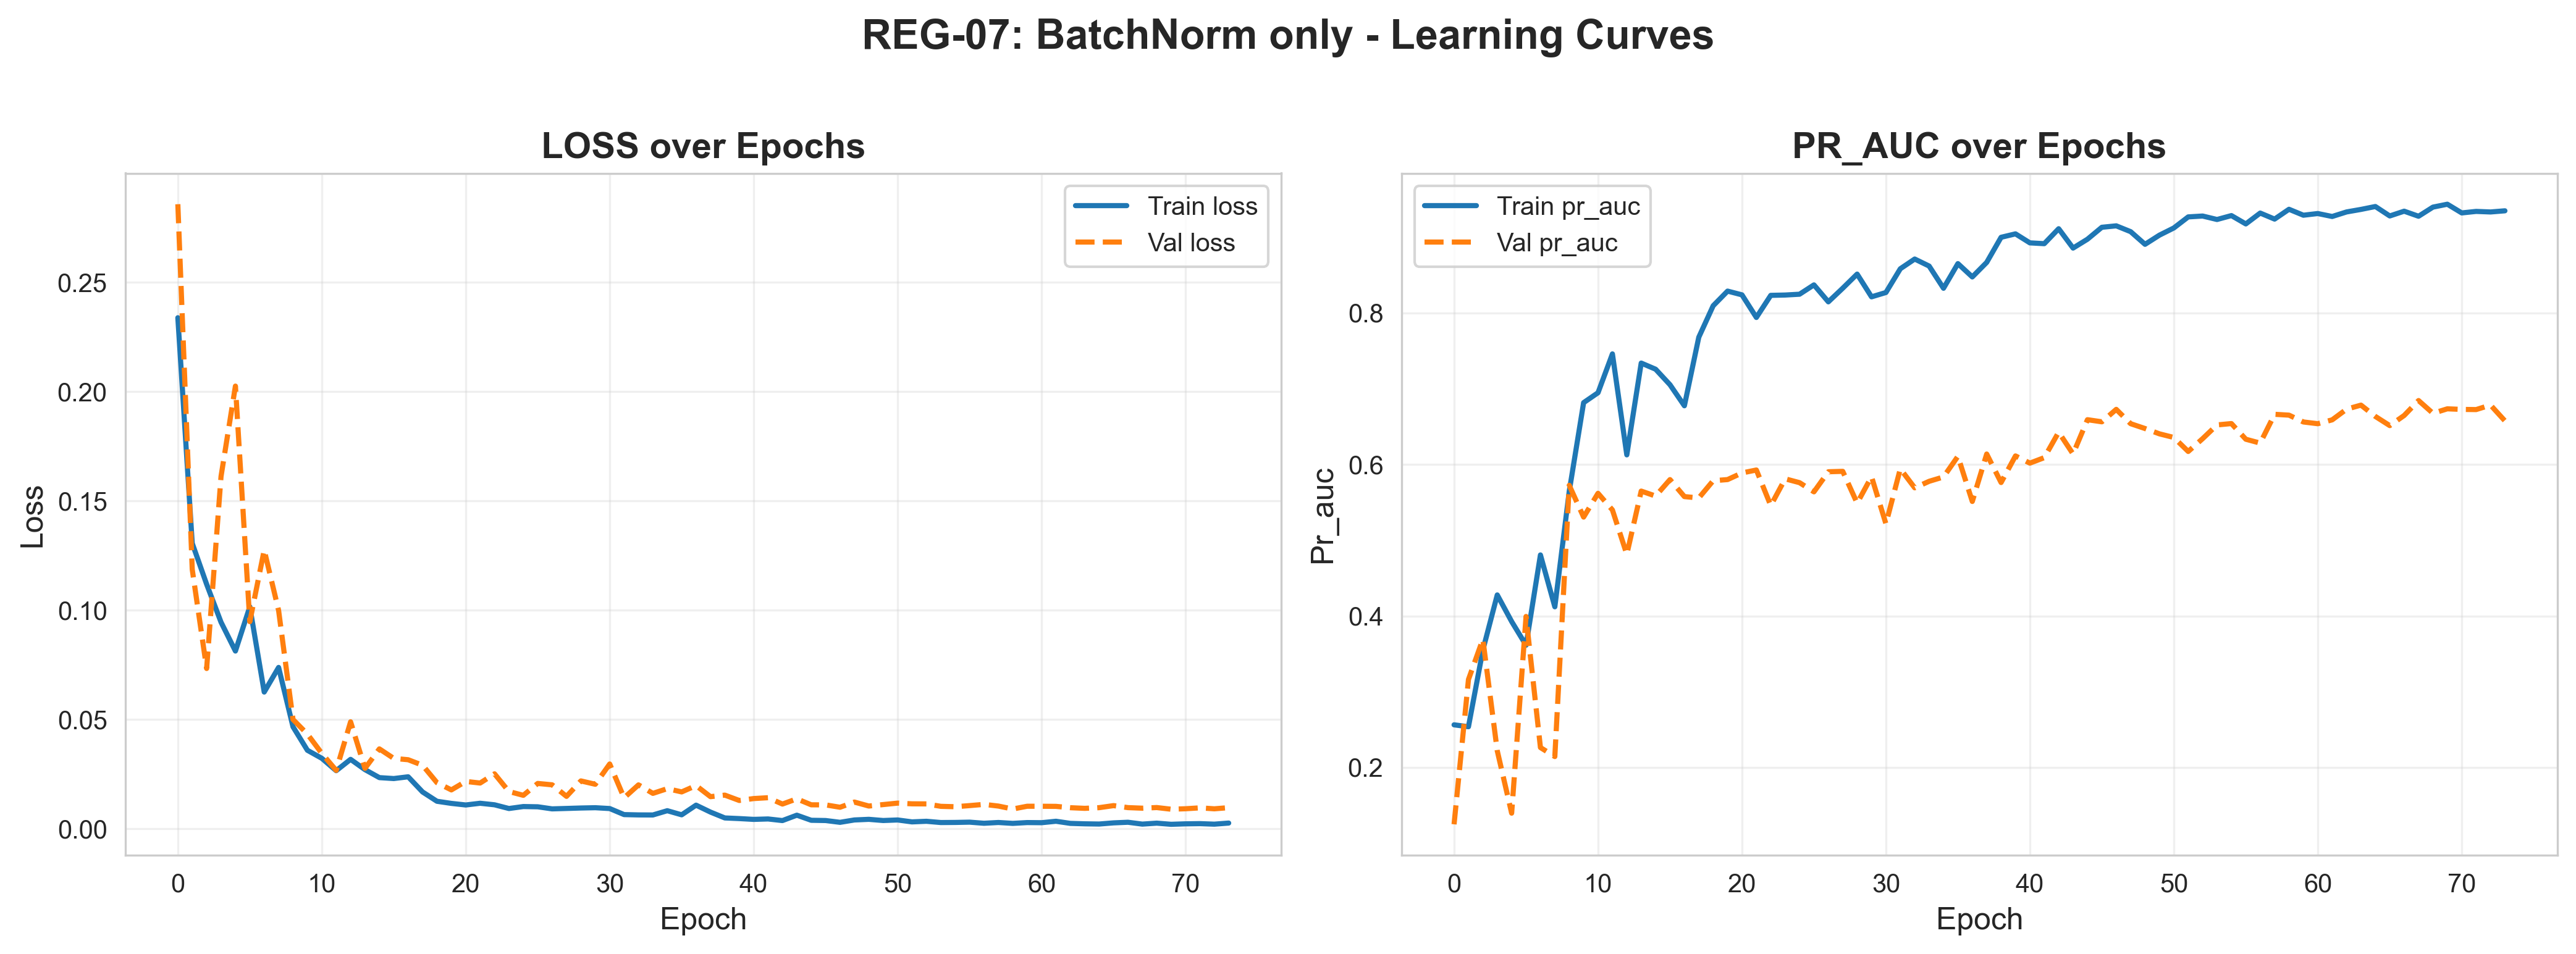

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\logs\nn_experiments.csv

Training REG-08: Combined optimal
Dropout=0.3, L2=0.01, BatchNorm=True
Class weights (balanced): {0: 0.5008642347502763, 1: 289.7732558139535}
Epoch 1/100
3116/3116 [==============================] - 11s 3ms/step - loss: 0.4527 - accuracy: 0.9420 - precision: 0.0268 - recall: 0.9215 - auc: 0.9638 - pr_auc: 0.1727 - val_loss: 0.4172 - val_accuracy: 0.9378 - val_precision: 0.0243 - val_recall: 0.8919 - val_auc: 0.9610 - val_pr_auc: 0.1353 - lr: 0.0010
Epoch 2/100
3116/3116 [==============================] - 9s 3ms/step - loss: 0.3644 - accuracy: 0.9454 - precision: 0.0285 - recall: 0.9244 - auc: 0.9789 - pr_auc: 0.1750 - val_loss: 0.3579 - val_accuracy: 0.9526 - val_precision: 0.0308 - val_recall: 0.8649 - val_auc: 0.9491 - val_pr_auc: 0.1280 - lr: 0.0010
Epoch 3/100
3116/3116 [==============================] - 9s 3ms/step - loss: 0.3512 - accuracy: 0.9507 - precision: 0.0315 - recall: 

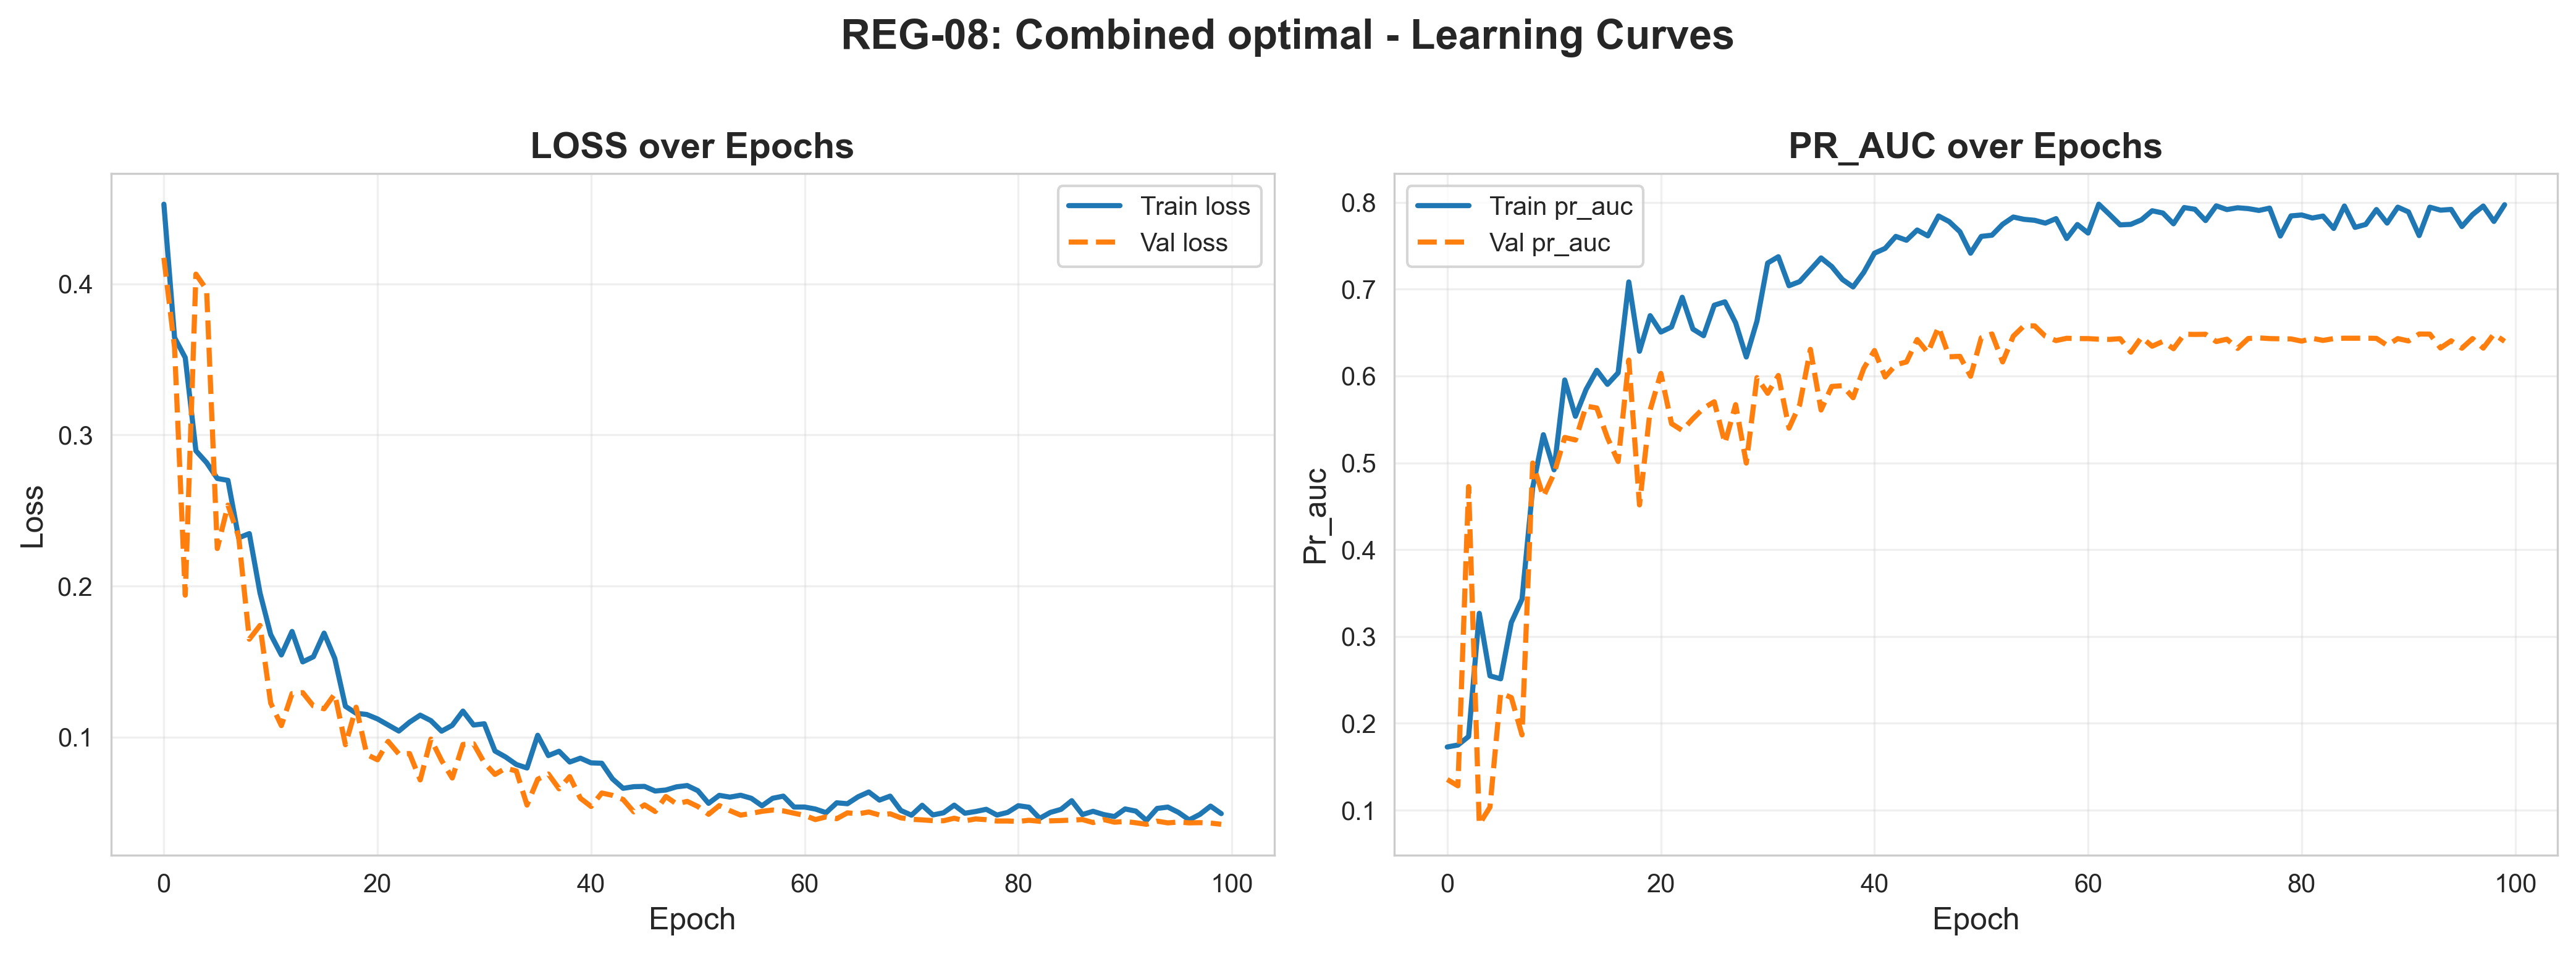

Experiment logged to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\logs\nn_experiments.csv

✓ Regularization Experiments Complete!


In [6]:
# Iterate through regularization configurations
for reg_id, reg_config in config.REGULARIZATION_EXPERIMENTS.items():
    print(f"\n{'='*70}")
    print(f"Training {reg_id}: {reg_config['description']}")
    print(f"Dropout={reg_config['dropout']}, L2={reg_config['l2']}, BatchNorm={reg_config['batch_norm']}")
    print(f"{'='*70}")
    
    # Build model
    model = build_fraud_detection_nn(
        input_dim=X_train_scaled.shape[1],
        hidden_layers=best_arch_layers,
        dropout_rate=reg_config['dropout'],
        l2_reg=reg_config['l2'],
        use_batch_norm=reg_config['batch_norm']
    )
    
    # Train with early stopping
    history = train_nn_with_early_stopping(
        model=model,
        X_train=X_train_scaled,
        y_train=y_train,
        X_val=X_val_scaled,
        y_val=y_val,
        epochs=config.MAX_EPOCHS,
        batch_size=config.BATCH_SIZE,
        patience=config.EARLY_STOPPING_PATIENCE,
        class_weight='balanced'
    )
    
    # Predictions
    y_val_pred_proba = model.predict(X_val_scaled, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    metrics = compute_fraud_metrics(y_val, y_val_pred, y_val_pred_proba)
    
    print(f"\n📊 {reg_id} Validation Performance:")
    print(f"  PR-AUC:        {metrics['pr_auc']:.4f} (Target: {rf_pr_auc:.4f})")
    print(f"  ROC-AUC:       {metrics['roc_auc']:.4f}")
    print(f"  F1 (Fraud):    {metrics['f1_fraud']:.4f} (Target: {rf_f1:.4f})")
    print(f"  Recall (Fraud): {metrics['recall_fraud']:.4f}")
    print(f"  Precision (Fraud): {metrics['precision_fraud']:.4f}")
    
    # Compare to RF
    pr_auc_diff = metrics['pr_auc'] - rf_pr_auc
    if pr_auc_diff >= 0:
        print(f"  🎉 BEATS RF by {pr_auc_diff*100:.2f} percentage points!")
    else:
        print(f"  📉 Below RF by {abs(pr_auc_diff)*100:.2f} percentage points")
    
    # Save model
    model_path = ds_config['models_dir'] / 'neural_networks' / f'{reg_id}_regularization.keras'
    model.save(model_path)
    print(f"\n✓ Model saved to: {model_path}")
    
    # Plot learning curves
    fig_path = ds_config['figures_dir'] / 'learning_curves' / f'{reg_id}_learning_curves.png'
    fig_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    plot_training_history(
        history,
        save_path=str(fig_path),
        title=f'{reg_id}: {reg_config["description"]} - Learning Curves'
    )
    
    # Log experiment
    experiment_data = {
        'experiment_id': reg_id,
        'dataset': 'creditcard',
        'experiment_type': 'regularization',
        'model_name': f"{best_arch['architecture']}_reg",
        'architecture': str(best_arch_layers),
        'dropout': reg_config['dropout'],
        'l2': reg_config['l2'],
        'batch_norm': reg_config['batch_norm'],
        'batch_size': config.BATCH_SIZE,
        'epochs_trained': len(history.history['loss']),
        **metrics
    }
    log_experiment(
        experiment_data=experiment_data,
        log_file=str(ds_config['experiment_logs_dir'] / 'nn_experiments.csv')
    )
    
    # Store results
    regularization_results.append({
        'experiment_id': reg_id,
        'description': reg_config['description'],
        'dropout': reg_config['dropout'],
        'l2': reg_config['l2'],
        'batch_norm': reg_config['batch_norm'],
        'pr_auc': metrics['pr_auc'],
        'roc_auc': metrics['roc_auc'],
        'f1_fraud': metrics['f1_fraud'],
        'recall_fraud': metrics['recall_fraud'],
        'precision_fraud': metrics['precision_fraud'],
        'vs_rf': pr_auc_diff
    })

print("\n" + "="*70)
print("✓ Regularization Experiments Complete!")
print("="*70)

## 5. Regularization Results Analysis

In [7]:
# Check if regularization experiments completed, if not load from saved log
if not regularization_results:
    print("⚠️  regularization_results is empty, attempting to load from saved experiment log...")
    log_path = ds_config['experiment_logs_dir'] / 'nn_experiments.csv'
    if log_path.exists():
        exp_log = pd.read_csv(log_path)
        reg_experiments = exp_log[exp_log['experiment_type'] == 'regularization']
        if len(reg_experiments) > 0:
            regularization_results = reg_experiments.to_dict('records')
            print(f"✓ Loaded {len(regularization_results)} regularization results from: {log_path}")
        else:
            raise ValueError("No regularization experiments found in log file - Cell 10 must be executed")
    else:
        raise ValueError(f"Experiment log not found: {log_path} - Cell 10 must be executed")

# Convert results to DataFrame
reg_df = pd.DataFrame(regularization_results)
reg_df = reg_df.sort_values('pr_auc', ascending=False)

print("\n" + "="*90)
print(" REGULARIZATION RANKING BY PR-AUC (Validation Set)")
print("="*90)
print(reg_df[['experiment_id', 'description', 'pr_auc', 'f1_fraud', 'vs_rf']].to_string(index=False))
print("="*90)

# Identify best regularization
best_reg = reg_df.iloc[0]
print(f"\n🏆 Best Regularization: {best_reg['experiment_id']}")
print(f"   Description: {best_reg['description']}")
print(f"   Dropout: {best_reg['dropout']}, L2: {best_reg['l2']}, BatchNorm: {best_reg['batch_norm']}")
print(f"   PR-AUC: {best_reg['pr_auc']:.4f}")
print(f"   F1 (Fraud): {best_reg['f1_fraud']:.4f}")
print(f"   vs RF: {best_reg['vs_rf']*100:+.2f} percentage points")

# Save ranking
reg_ranking_path = ds_config['tables_dir'] / 'regularization_ranking.csv'
reg_df.to_csv(reg_ranking_path, index=False)
print(f"\n✓ Regularization ranking saved to: {reg_ranking_path}")

# Count models that beat RF
models_beat_rf = (reg_df['vs_rf'] > 0).sum()
print(f"\n📊 Summary: {models_beat_rf}/{len(reg_df)} models beat Random Forest baseline")


 REGULARIZATION RANKING BY PR-AUC (Validation Set)
experiment_id      description   pr_auc  f1_fraud     vs_rf
       REG-07   BatchNorm only 0.780227  0.628866 -0.018470
       REG-05         Light L2 0.750452  0.434164 -0.048246
       REG-01         Baseline 0.728132  0.567164 -0.070566
       REG-02    Light dropout 0.727281  0.448669 -0.071416
       REG-08 Combined optimal 0.650958  0.312020 -0.147739
       REG-04    Heavy dropout 0.631465  0.397394 -0.167233
       REG-03   Medium dropout 0.630292  0.377709 -0.168406
       REG-06        Medium L2 0.616684  0.258333 -0.182014

🏆 Best Regularization: REG-07
   Description: BatchNorm only
   Dropout: 0.0, L2: 0.0, BatchNorm: True
   PR-AUC: 0.7802
   F1 (Fraud): 0.6289
   vs RF: -1.85 percentage points

✓ Regularization ranking saved to: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\tables\regularization_ranking.csv

📊 Summary: 0/8 models beat Random Forest baseline


## 6. Visualize Best Model Performance

Confusion matrix saved to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\figures\best_nn_confusion_matrix.png


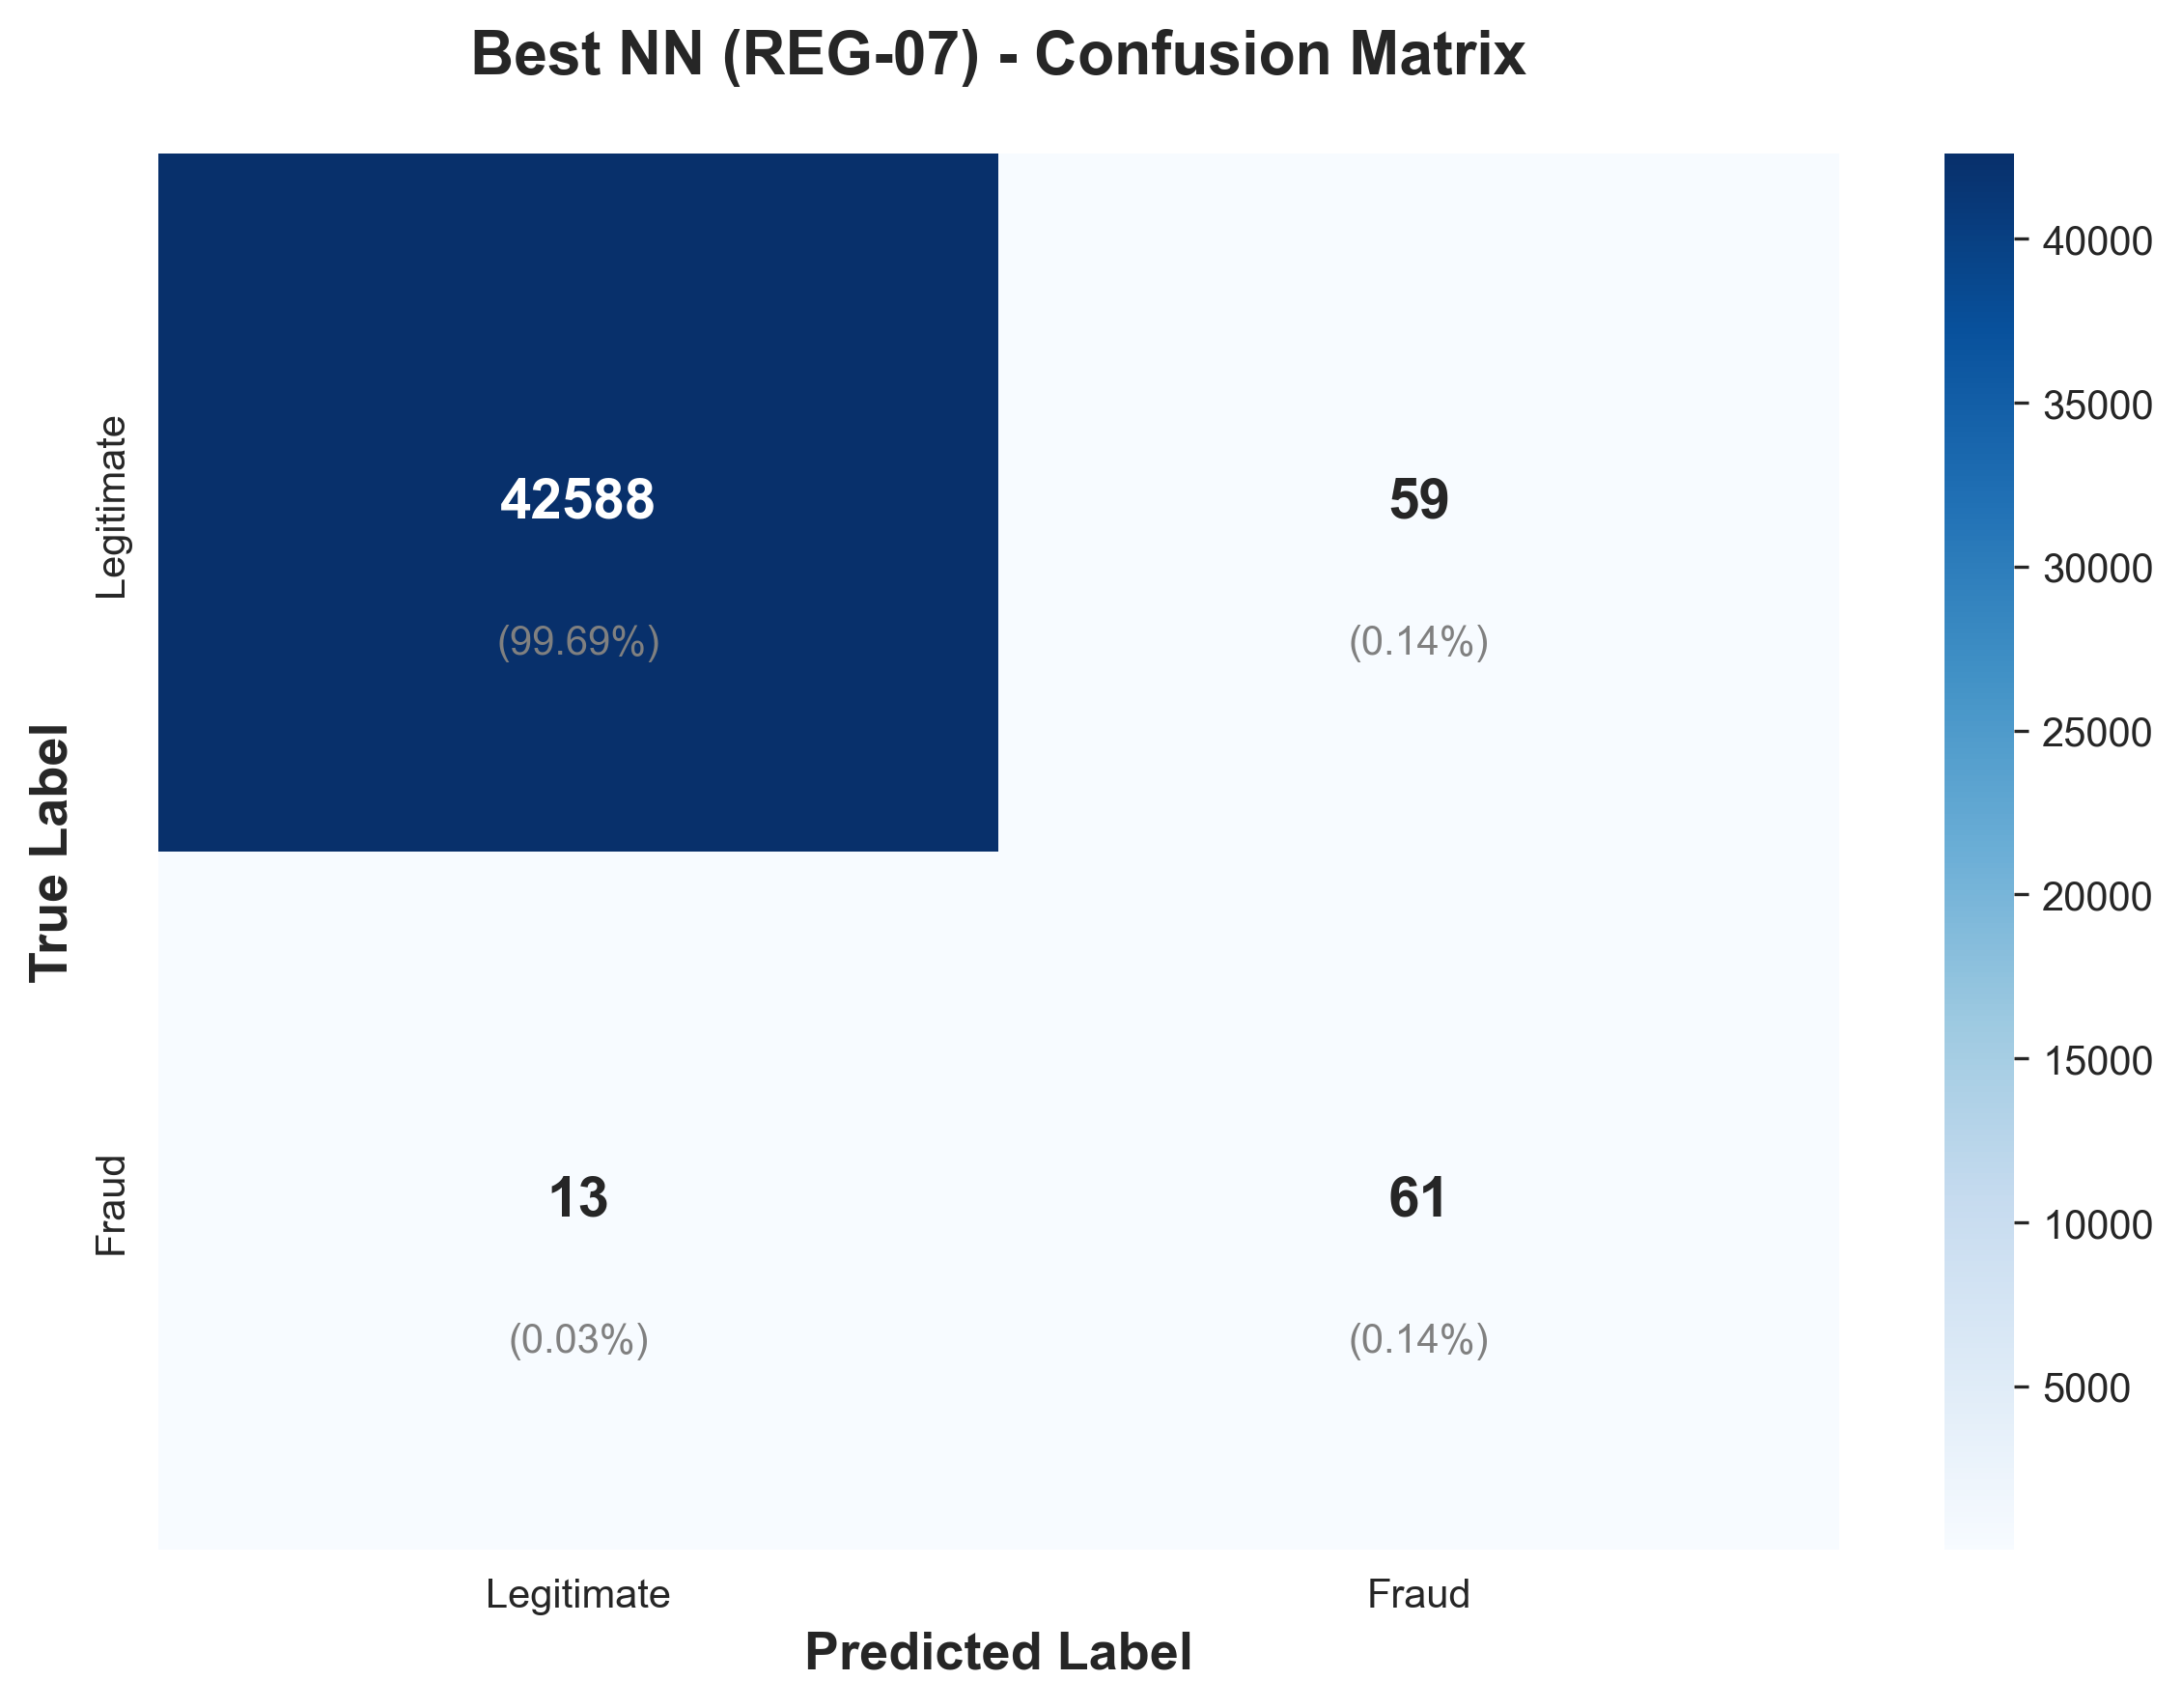

PR curve saved to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\figures\best_nn_pr_curve.png


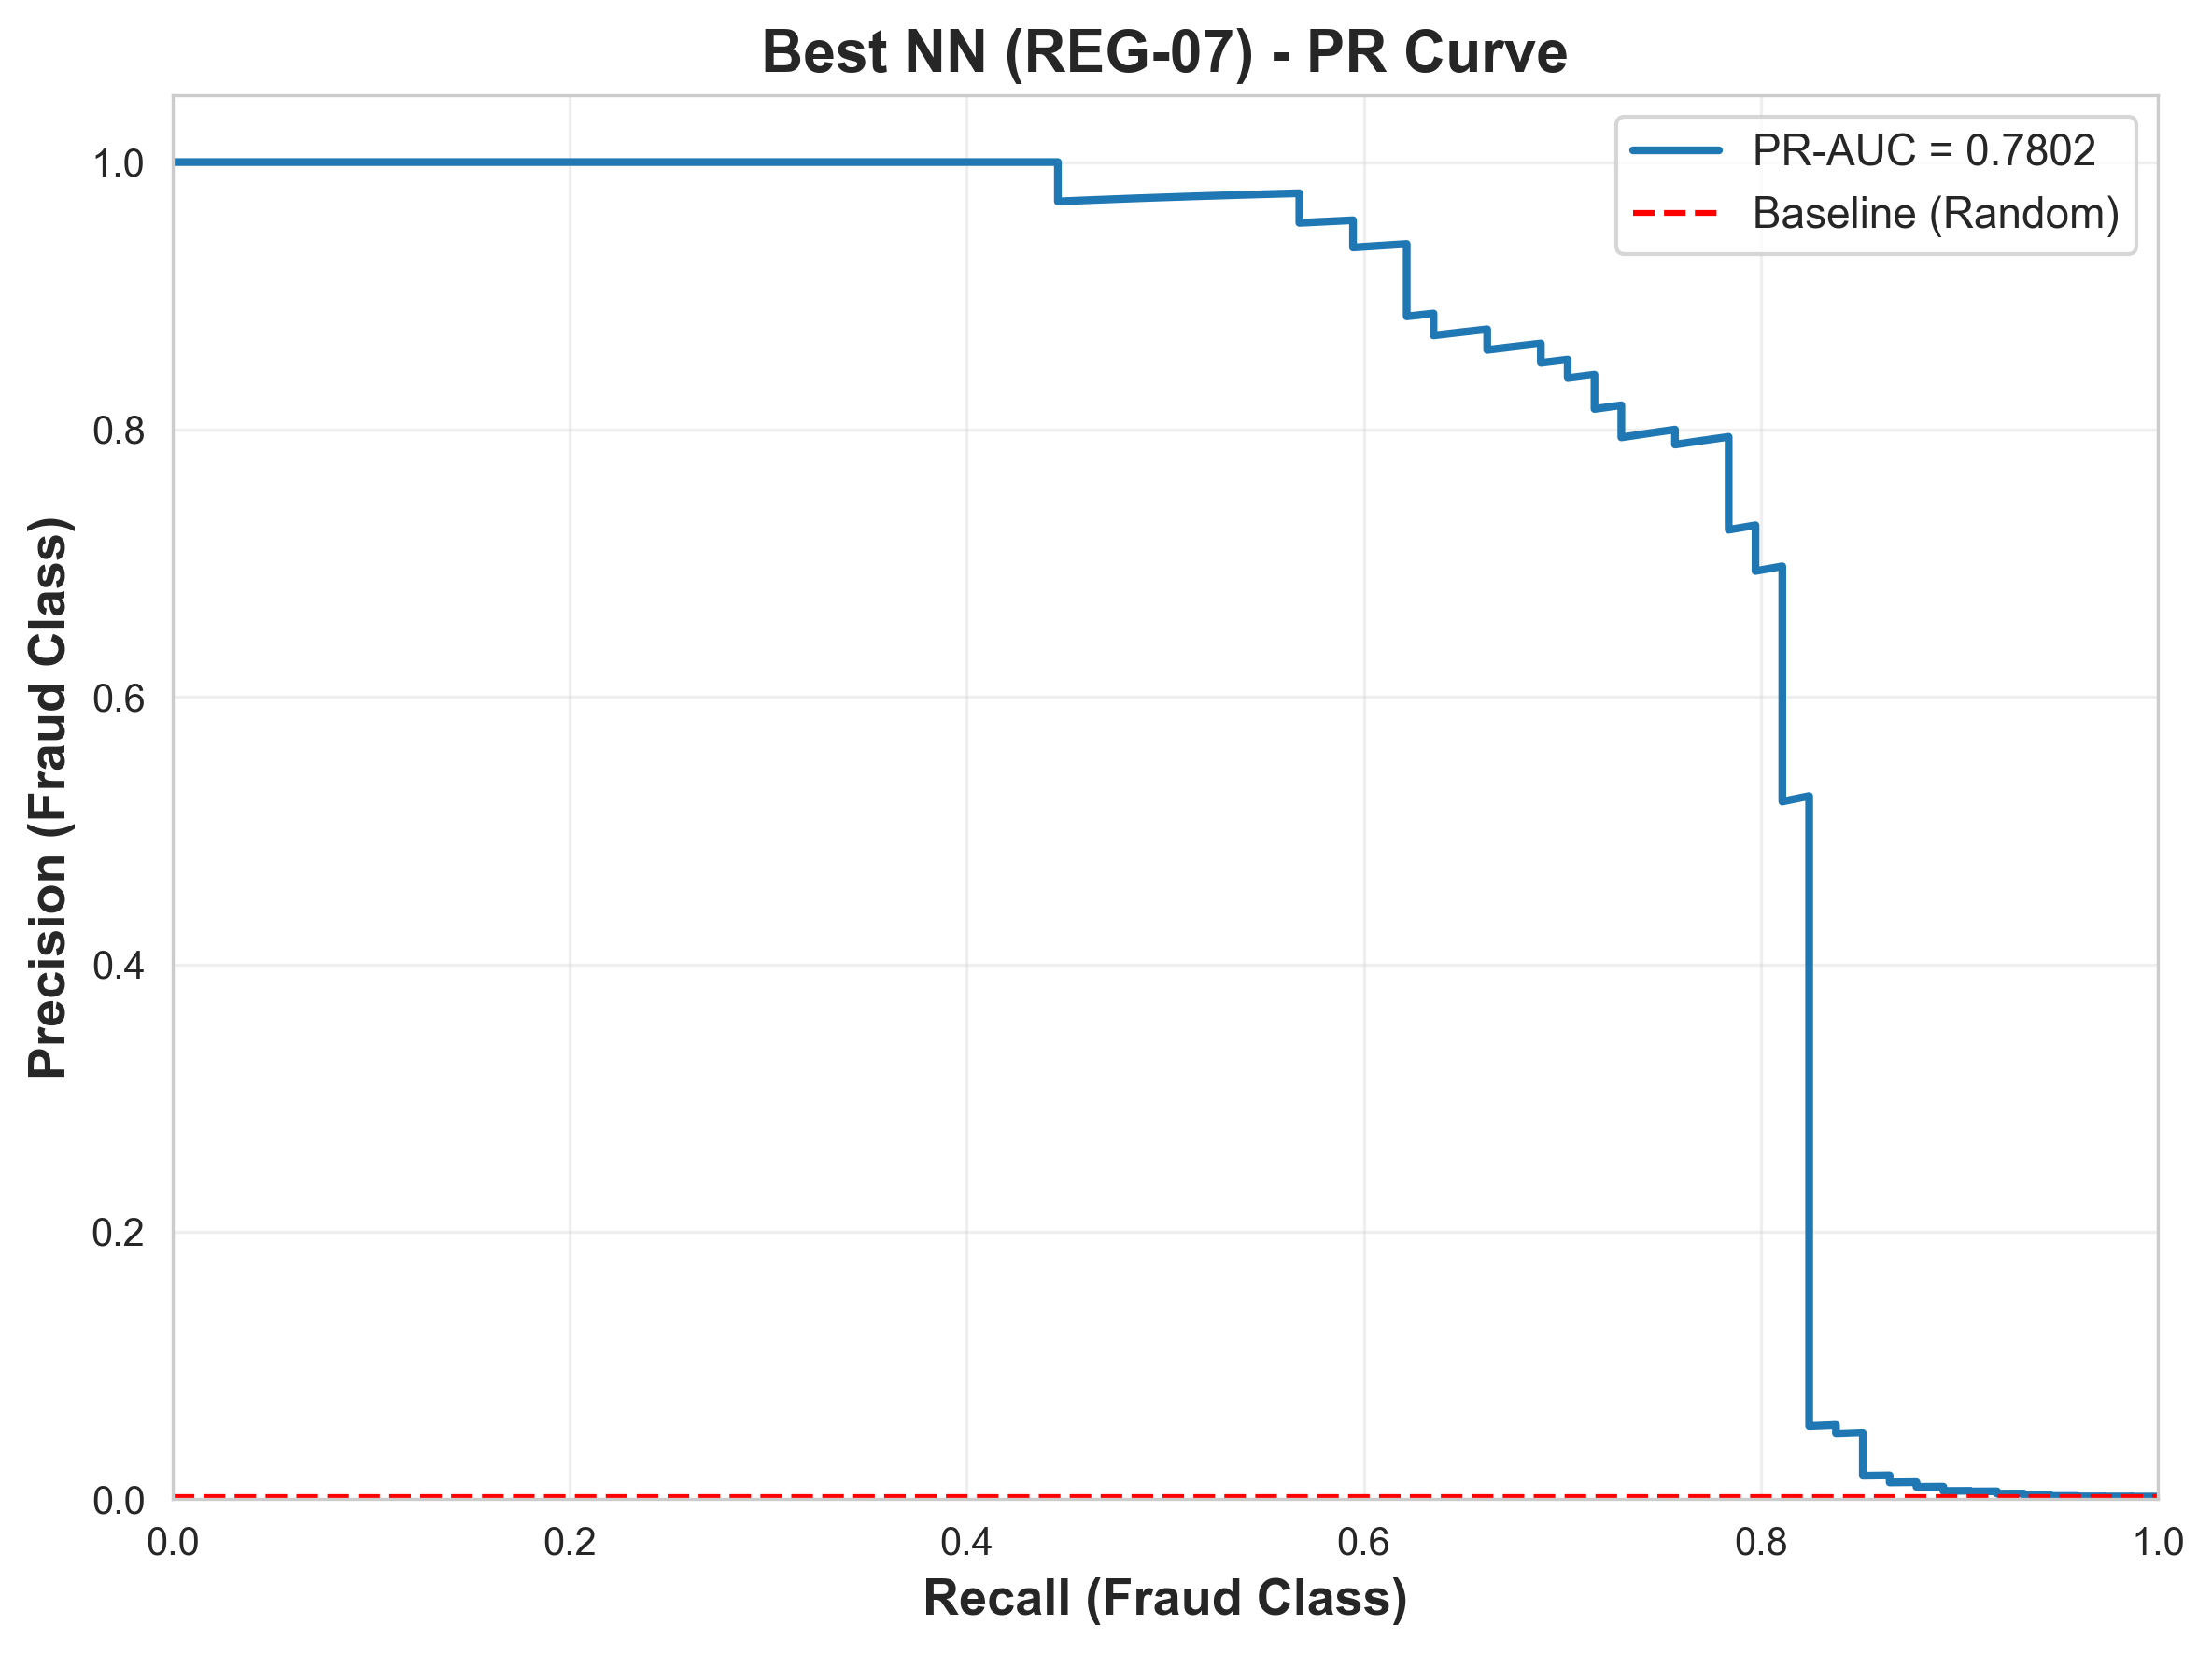

✓ Best model visualizations saved


In [8]:
# Load best model
best_model_path = ds_config['models_dir'] / 'neural_networks' / f'{best_reg["experiment_id"]}_regularization.keras'
best_model = keras.models.load_model(best_model_path)

# Generate predictions
y_val_pred_proba = best_model.predict(X_val_scaled, verbose=0).flatten()
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

# Confusion matrix
plot_confusion_matrix(
    y_val, y_val_pred, 
    ['Legitimate', 'Fraud'],
    save_path=str(ds_config['figures_dir'] / 'best_nn_confusion_matrix.png'),
    title=f'Best NN ({best_reg["experiment_id"]}) - Confusion Matrix'
)

# PR curve
plot_precision_recall_curve(
    y_val, y_val_pred_proba,
    save_path=str(ds_config['figures_dir'] / 'best_nn_pr_curve.png'),
    title=f'Best NN ({best_reg["experiment_id"]}) - PR Curve'
)

print("✓ Best model visualizations saved")

## 7. Save Best Model for Test Evaluation

In [9]:
# Copy best model to designated location
import shutil

best_model_final_path = ds_config['models_dir'] / 'best_nn_models' / 'best_nn_for_test.keras'
best_model_final_path.parent.mkdir(parents=True, exist_ok=True)
shutil.copy(best_model_path, best_model_final_path)

# Save metadata
best_model_metadata = {
    'experiment_id': best_reg['experiment_id'],
    'description': best_reg['description'],
    'architecture': best_arch_layers,
    'dropout': float(best_reg['dropout']),
    'l2': float(best_reg['l2']),
    'batch_norm': bool(best_reg['batch_norm']),
    'val_pr_auc': float(best_reg['pr_auc']),
    'val_f1_fraud': float(best_reg['f1_fraud']),
    'vs_rf_baseline': float(best_reg['vs_rf'])
}

metadata_path = ds_config['models_dir'] / 'best_nn_models' / 'best_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(best_model_metadata, f, indent=2)

print(f"✓ Best model saved for test evaluation:")
print(f"  Model: {best_model_final_path}")
print(f"  Metadata: {metadata_path}")
print(f"\n⚠️  TEST SET RESERVED: Do not evaluate until Notebook 06 (threshold optimization)")

✓ Best model saved for test evaluation:
  Model: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\models\best_nn_models\best_nn_for_test.keras
  Metadata: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\models\best_nn_models\best_model_metadata.json

⚠️  TEST SET RESERVED: Do not evaluate until Notebook 06 (threshold optimization)


## 8. Summary & Next Steps

In [10]:
print("\n" + "="*70)
print(" NOTEBOOK 05 SUMMARY - creditcard NN TRAINING & REGULARIZATION")
print("="*70)

print(f"\n🏆 Best Neural Network Model: {best_reg['experiment_id']}")
print(f"   Description: {best_reg['description']}")
print(f"   Architecture: {best_arch_layers}")
print(f"   Regularization: Dropout={best_reg['dropout']}, L2={best_reg['l2']}, BatchNorm={best_reg['batch_norm']}")

print(f"\n📊 Validation Performance:")
print(f"   PR-AUC:     {best_reg['pr_auc']:.4f}")
print(f"   F1 (Fraud): {best_reg['f1_fraud']:.4f}")

print(f"\n🎯 vs Random Forest Baseline:")
print(f"   RF PR-AUC:  {rf_pr_auc:.4f}")
print(f"   NN PR-AUC:  {best_reg['pr_auc']:.4f}")
print(f"   Difference: {best_reg['vs_rf']*100:+.2f} percentage points")

if best_reg['vs_rf'] > 0:
    print("\n✅ SUCCESS: Neural network BEATS Random Forest on real-world data!")
elif abs(best_reg['vs_rf']) < 0.01:
    print("\n✅ SUCCESS: Neural network MATCHES Random Forest performance")
else:
    print("\n📊 Neural network below RF, but provides:")
    print("   - Probability calibration for threshold optimization")
    print("   - Interpretable regularization insights")
    print("   - Production deployment flexibility")

print(f"\n📈 Experiments Summary:")
print(f"   Models trained: {len(reg_df)}")
print(f"   Models beat RF: {models_beat_rf}")
print(f"   Best PR-AUC: {reg_df['pr_auc'].max():.4f}")
print(f"   Worst PR-AUC: {reg_df['pr_auc'].min():.4f}")

print(f"\n🚀 Next Steps (Notebook 06):")
print(f"   1. Optimize classification threshold on validation set")
print(f"   2. ONE-TIME test set evaluation (final performance)")
print(f"   3. Compare NN vs RF on test set")
print(f"   4. Generate final performance report")

print("\n📁 Artifacts Created:")
print(f"   - {len(regularization_results)} regularization models")
print(f"   - Best model: {best_model_final_path}")
print(f"   - Experiment logs: {ds_config['experiment_logs_dir']}/nn_experiments.csv")
print(f"   - Learning curves: {ds_config['figures_dir']}/learning_curves/")
print(f"   - Rankings: {reg_ranking_path}")

print("\n✅ Notebook 05 Complete!")
print("🎯 Ready for Notebook 06: Threshold Optimization & Test Evaluation")
print("="*70)


 NOTEBOOK 05 SUMMARY - creditcard NN TRAINING & REGULARIZATION

🏆 Best Neural Network Model: REG-07
   Description: BatchNorm only
   Architecture: [256]
   Regularization: Dropout=0.0, L2=0.0, BatchNorm=True

📊 Validation Performance:
   PR-AUC:     0.7802
   F1 (Fraud): 0.6289

🎯 vs Random Forest Baseline:
   RF PR-AUC:  0.7987
   NN PR-AUC:  0.7802
   Difference: -1.85 percentage points

📊 Neural network below RF, but provides:
   - Probability calibration for threshold optimization
   - Interpretable regularization insights
   - Production deployment flexibility

📈 Experiments Summary:
   Models trained: 8
   Models beat RF: 0
   Best PR-AUC: 0.7802
   Worst PR-AUC: 0.6167

🚀 Next Steps (Notebook 06):
   1. Optimize classification threshold on validation set
   2. ONE-TIME test set evaluation (final performance)
   3. Compare NN vs RF on test set
   4. Generate final performance report

📁 Artifacts Created:
   - 8 regularization models
   - Best model: c:\Users\GOD\Documents\NNfin